In [1]:
# 구글드라이브와 연결후 드라이브에 폴더 업로드함
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# 디렉토리 확인함
import os

img_dir = '/content/drive/MyDrive/Colab Notebooks/mydrive/data'
os.listdir(img_dir)

['.DS_Store', 'Free', 'Full']

In [3]:
# skimage imagecollection 통해서 해당위치에 있는 이미지파일들을 가져옴
import skimage.io as io
Free_images = io.ImageCollection('/content/drive/MyDrive/Colab Notebooks/mydrive/data/Free/*')
Full_images = io.ImageCollection('/content/drive/MyDrive/Colab Notebooks/mydrive/data/Full/*')

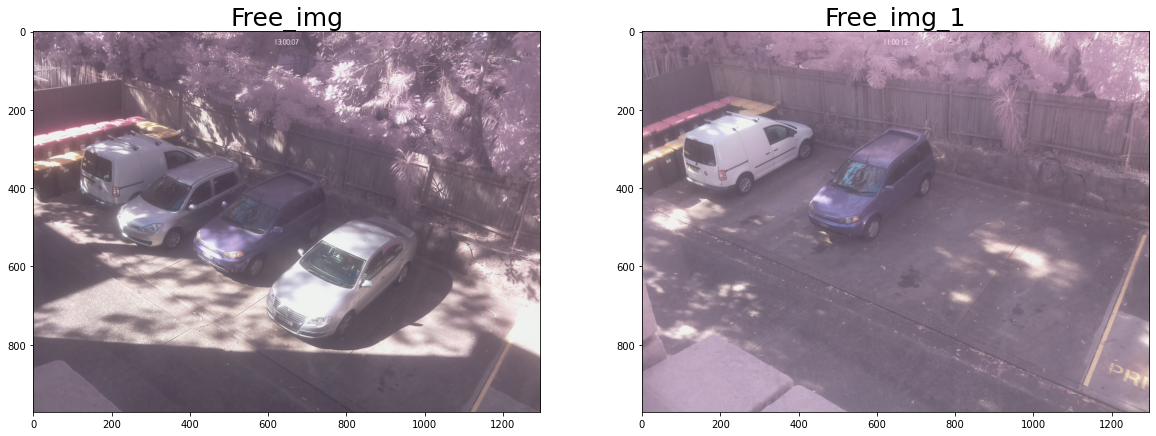

In [4]:
import matplotlib.pyplot as plt

# Free_images 의 이미지 중 하나를 시각화 
plt.figure(figsize=(20,20))
free_img = Free_images[100]
plt.subplot(1,2,1)
plt.title('Free_img', fontsize=25)
plt.imshow(free_img)

free_img_1 = Free_images[50]
plt.subplot(1,2,2)
plt.title('Free_img_1', fontsize=25)
plt.imshow(free_img_1);

# 비어있는 공간이 어디가 비어있는지는 라벨링이 되어 있지는 않음
# 어느 공간이 비어있는지는 알 수 없지만 이후에 feature activation map을 통해서 어느 공간이 비어있는지 시각화 예정

In [5]:
print(free_img.shape)     # 하나의 free_img shape 확인
print(len(Free_images))   # 전체 Free 이미지 갯수 확인

(972, 1296, 3)
1067


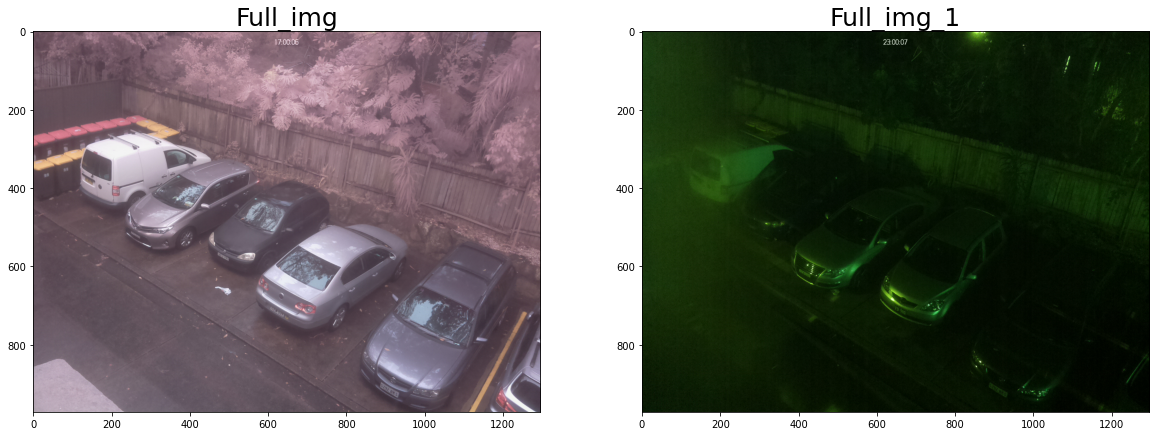

In [6]:
# Full_images 의 이미지 중 하나를 시각화 
plt.figure(figsize=(20,20))

full_img = Full_images[99]
plt.subplot(1,2,1)
plt.title('Full_img', fontsize=25)
plt.imshow(full_img)

full_img_1 = Full_images[100]
plt.subplot(1,2,2)
plt.title('Full_img_1', fontsize=25)
plt.imshow(full_img_1);

In [9]:
print(full_img.shape)     # 하나의 Full_img shape 확인
print(len(Full_images))   # 전체 Full 이미지 갯수 확인

(972, 1296, 3)
2195


In [10]:
%config InlineBackend.figure_format = 'retina'  # 그래프 선명하게 

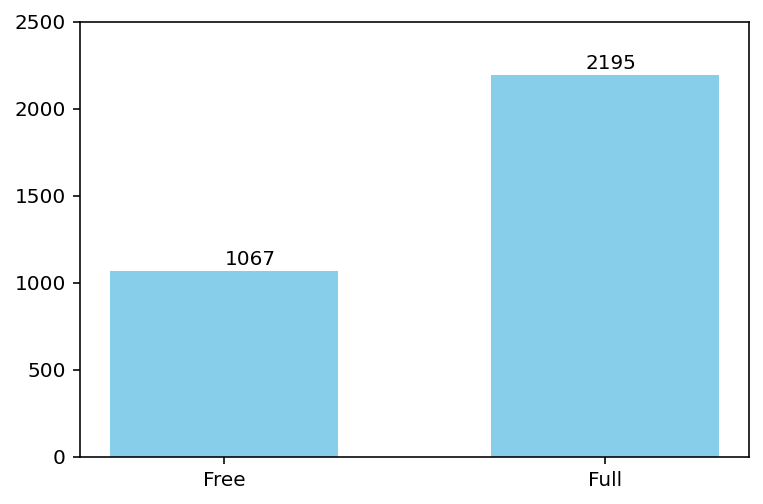

In [11]:
# Free, Full 이미지의 갯수 시각화
# Full 이미지가 약 2배정도 많음
import numpy as np

x = np.arange(2)
years = ['Free', 'Full']
values = [len(Free_images), len(Full_images)]

plt.bar(x, values, width=0.6, color='skyblue')
plt.text(0.0003,1100,'1067')
plt.text(0.95,2230,'2195')
plt.xticks(x, years)
plt.ylim([0,2500])     

plt.show()

In [12]:
print(len(Free_images), len(Full_images))

1067 2195


In [13]:
print(len(Free_images) + len(Full_images))

3262


In [14]:
# 타겟 분포 확인 및 베이스라인
# 모두 full로 예측하는 모델의 정확도는 67%이므로 이를 넘어야 모델을 만드는 의미가 있음
print(len(Free_images)/(len(Free_images) + len(Full_images))*100)
print(len(Full_images)/(len(Free_images) + len(Full_images))*100)

32.709993868792154
67.29000613120785


In [15]:
# 전이학습에 사용할 모델
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [17]:
# 데이터 증강에 사용할 모듈
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [18]:
# 기타 모듈 및 랜덤 고정
import tensorflow as tf
import random

from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.callbacks import ModelCheckpoint,EarlyStopping

random.seed(1)
tf.random.set_seed(1)
np.random.seed(1)
os.environ["PYTHONHASHSEED"] = str(1)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)

In [19]:
# 데이터 증강
# 학습데이터에 적용할 generator 
train_datagen = ImageDataGenerator(rotation_range=20,   # 이미지 회전
                                   width_shift_range=0.1,   # 이미지 가로 방향으로 이동
                                   height_shift_range=0.1,    # 이미지 세로 방향으로 이동
                                   brightness_range=[0.8, 1.2],   # 이미지 밝기 범위
                                   shear_range=0.01,    # 이미지 굴절도
                                   zoom_range=[0.9, 1.1],   # 이미지 확대 범위
                                   validation_split=0.1,    # 학습데이터에서 떼어낼 검증데이터 
                                   preprocessing_function=preprocess_input)   # 해당 모델의 데이터에 적용된 전처리 함수

In [20]:
# 검증데이터에 적용할 generator
val_datagen = ImageDataGenerator(validation_split=0.1,
                                 preprocessing_function=preprocess_input)

In [21]:
# train generator 이용하여 학습데이터 생성
# 전체 이미지의 90%가 학습데이터
train_gen = train_datagen.flow_from_directory(img_dir,  # 디렉토리의 이미지를 모두 불러옴
                                              target_size=(224,224),  # 이미지 크기 조절
                                              classes=['Full','Free'],  # 클래스 분류
                                              class_mode='categorical',   # 클래스 모드(카테고리)
                                              batch_size=32,    # 배치사이즈
                                              shuffle=True,  # 이미지 무작위로 섞음
                                              subset='training')

Found 2937 images belonging to 2 classes.


In [22]:
# val generator 이용하여 검증데이터 생성
# 전체 이미지의 10%가 검증데이터
val_gen = val_datagen.flow_from_directory(img_dir,
                                          target_size=(224,224),
                                          classes=['Full','Free'],
                                          class_mode='categorical',
                                          batch_size=32,
                                          shuffle=False,  # 무작위로 섞을 필요 없음
                                          subset='validation')

Found 325 images belonging to 2 classes.


In [23]:
print(val_gen.class_indices)    # 클래스 분류 확인

{'Full': 0, 'Free': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


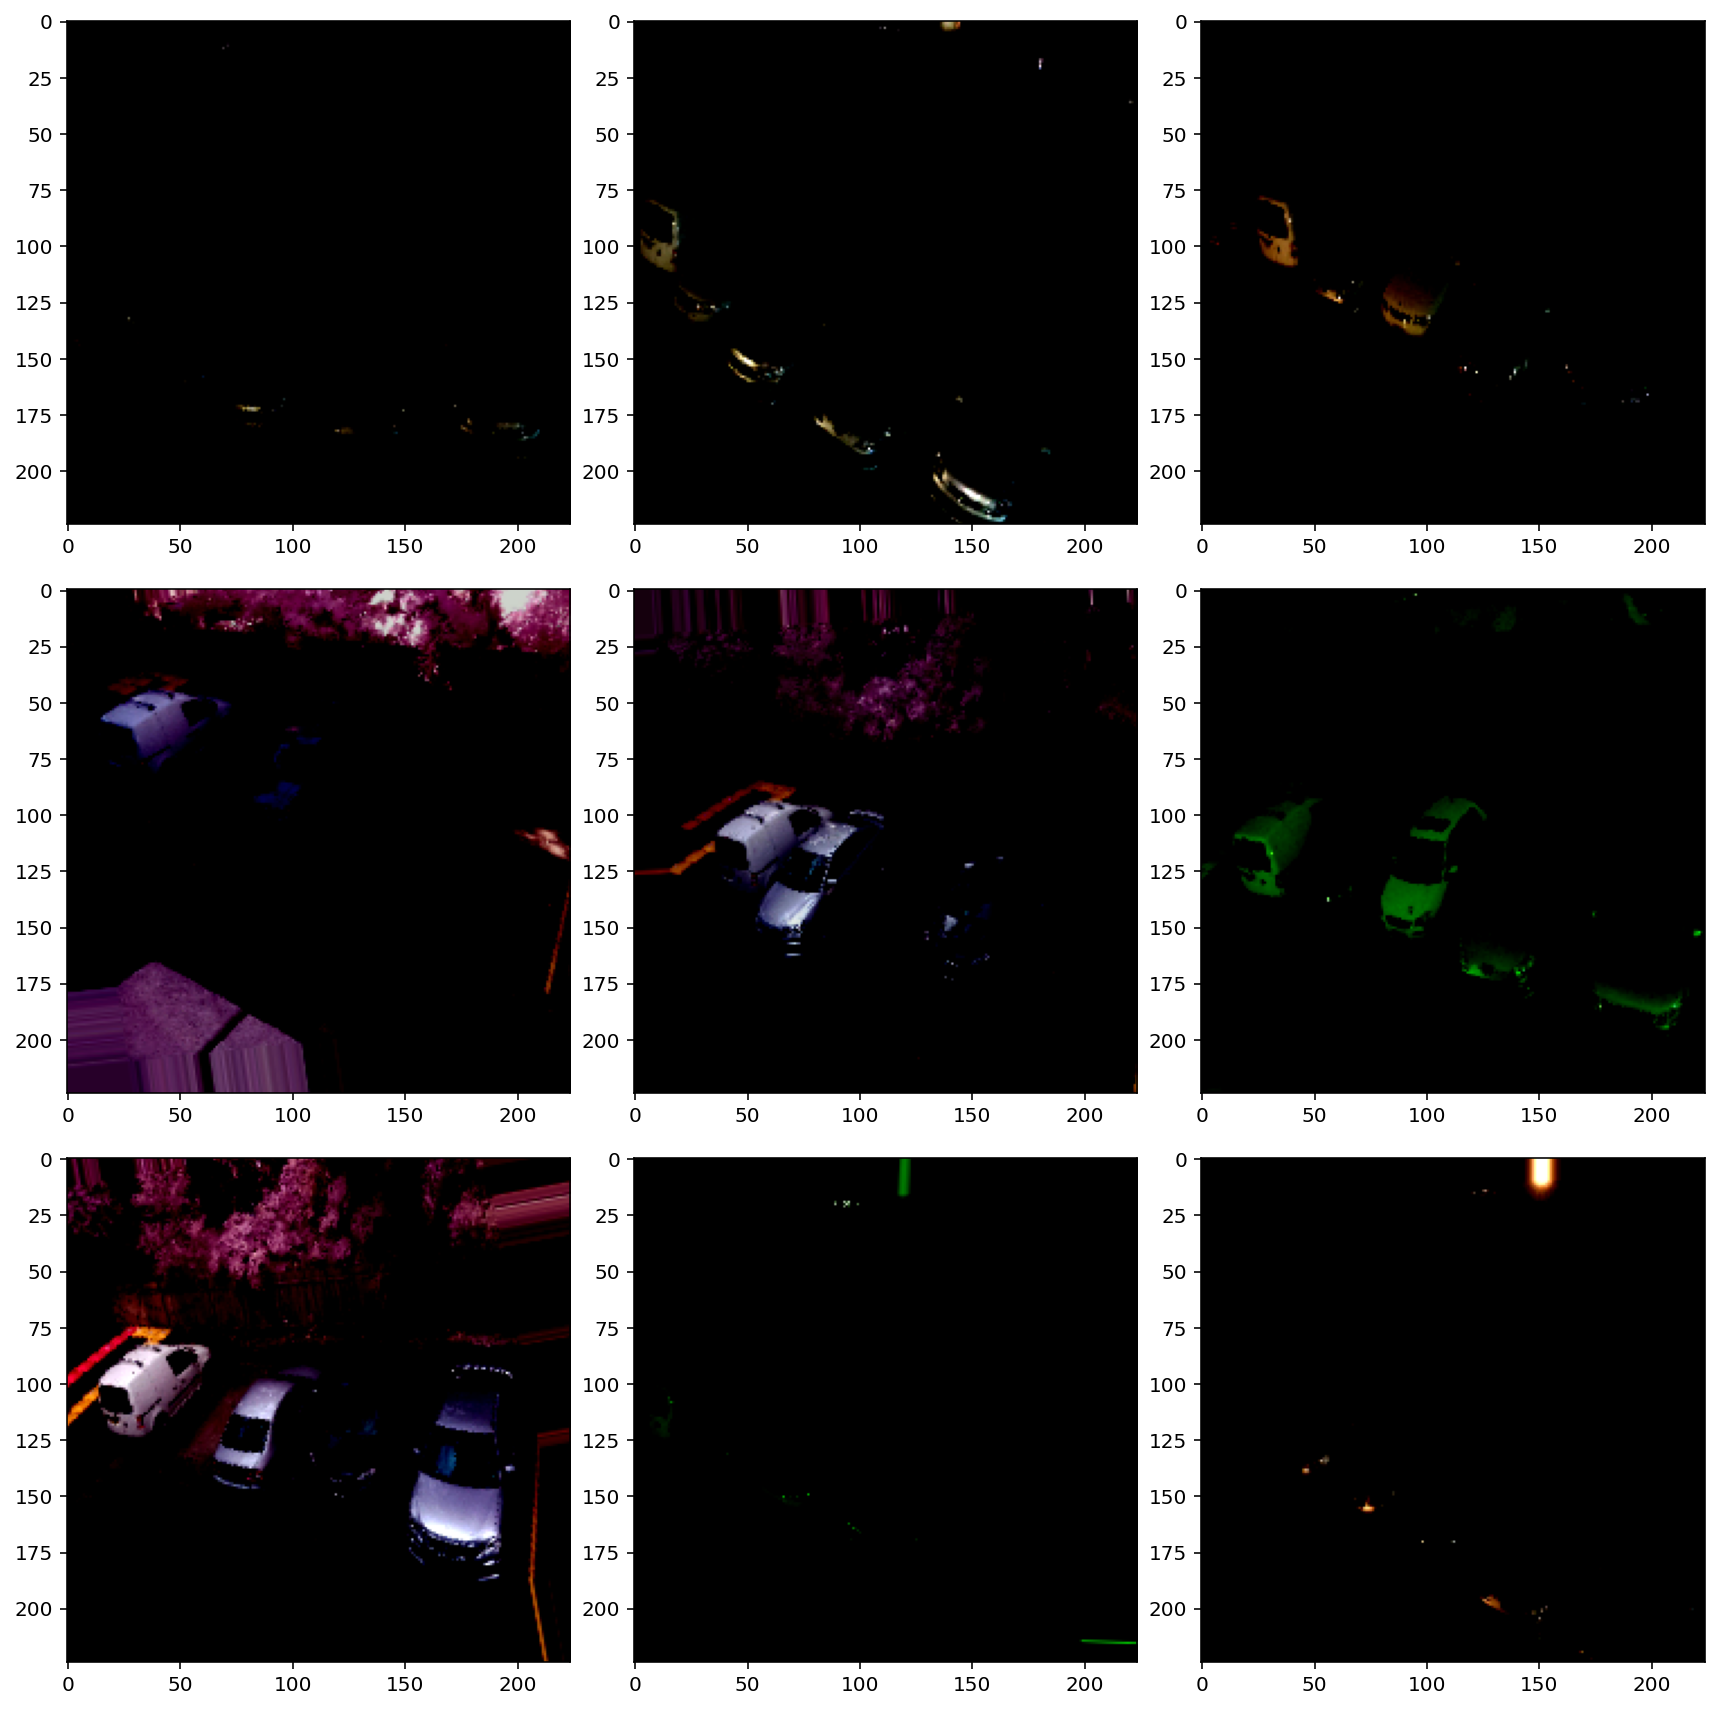

In [24]:
# 데이터 증강으로 만들어진 이미지 확인
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
# 사용할 전이학습 모델 다운로드
from keras.models import Model, load_model

base_model = MobileNetV2(input_shape=(224,224,3),  # 입력 데이터 shape
                         weights='imagenet',    # imagenet으로 학습된 가중치 가져옴
                         include_top=False)     # 최상위의 분류 관련 레이어 제거


9420800/9406464 [==============================] - 0s 0us/step


In [26]:
# 이미 학습된 레이어의 가중치 동결시켜줌
for layer in base_model.layers:  
    layer.trainable = False

In [27]:
x = base_model.output
x = GlobalAveragePooling2D()(x)   # 전이학습 모델의 아웃풋을 1차원으로 펴줌
output = Dense(2, # 2개의 카테고리 분류 (Full, Free)문제 이므로 Dense 레이어는 2로 설정, 활성화함수로 softmax사용
               activation='softmax')(x)

model = Model(inputs=base_model.input,    # 기존 전이학습모델의 인풋과, 새로 정의한 아웃풋을 넣어 하나의 모델로 만들어줌
              outputs=output)

model.compile(optimizer='adam',     # 모델 컴파일, 옵티마이저는 adam 사용
              loss='categorical_crossentropy',  # 두 개의 카테고리 분류 문제이므로 손실은 categorical_crossentropy 사용
              metrics=['acc'])    # 메트릭은 정확도 사용

model.summary()   # 모델구조 확인

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [28]:
# model 학습
# early stopping, model checkpoint 사용
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)   # 검증데이터의 loss를 모니터링함. loss를 최소화 시켜야 하므로 mode는 min 설정
mc = ModelCheckpoint('MobileNetV2_04.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks = [es, mc])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
92/92 [==============================] - 461s 5s/step - loss: 0.5268 - acc: 0.7427 - val_loss: 0.3250 - val_acc: 0.9292

Epoch 00001: val_acc improved from -inf to 0.92923, saving model to MobileNetV2_04.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
92/92 [==============================] - 215s 2s/step - loss: 0.2770 - acc: 0.8976 - val_loss: 0.3360 - val_acc: 0.8615

Epoch 00002: val_acc did not improve from 0.92923
Epoch 3/20
92/92 [==============================] - 225s 2s/step - loss: 0.2101 - acc: 0.9253 - val_loss: 0.3800 - val_acc: 0.8092

Epoch 00003: val_acc did not improve from 0.92923
Epoch 4/20
92/92 [==============================] - 217s 2s/step - loss: 0.1861 - acc: 0.9337 - val_loss: 0.2856 - val_acc: 0.8862

Epoch 00004: val_acc did not improve from 0.92923
Epoch 5/20
92/92 [==============================] - 225s 2s/step - loss: 0.1737 - acc: 0.9346 - val_loss: 0.2850 - val_acc: 0.8738

Epoch 00005: val_acc did not improve from 0.92923
Epoch 6/20
92/92 [==============================] - 217s 2s/step - loss: 0.1635 - acc: 0.9355 - val_loss: 0.3464 - val_acc: 0.8400

Epoch 00006: val_acc did not improve from 0.92923
Epoch 7/20
92/92 [==============================] - 227s 2s/step - loss: 0.1640 - acc: 0.9

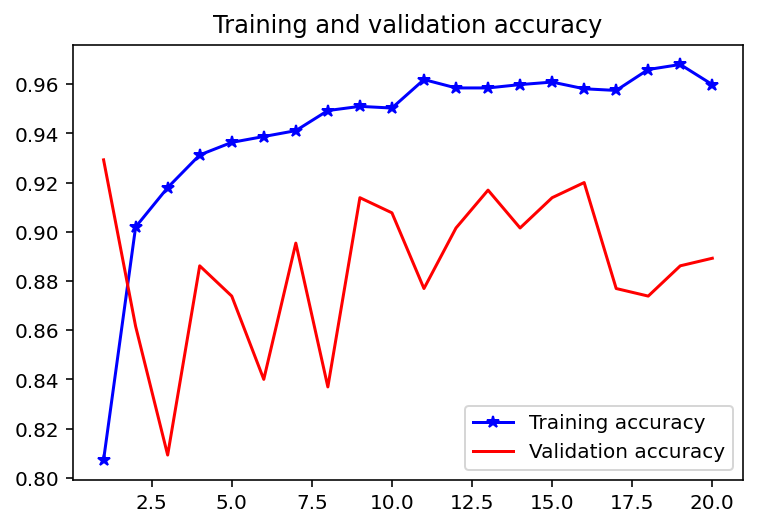

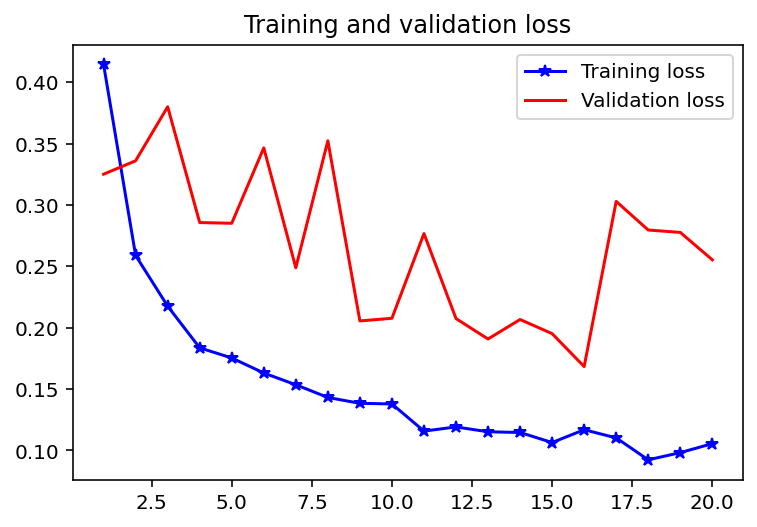

In [29]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim = [0,1]

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylim = [0,1]

plt.show()

In [30]:
# 정확도 88.92%로 베이스라인은 넘음
score = model.evaluate(val_gen, batch_size=32)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

11/11 [==============================] - 17s 1s/step - loss: 0.2553 - acc: 0.8892
Score Accuracy : 88.92%


In [31]:
model = load_model('MobileNetV2_04.h5')   # 위에서 저장한 모델 가져옴

last_weight = model.layers[-1].get_weights()[0] # 마지막 레이어의 가중치 따로 저장해둠

new_model = Model(inputs=model.input,   # 기존 모델의 입력을 인풋으로 하고, 두 가지를 아웃풋으로 하는 새로운 모델을 만듦
                  outputs=(model.layers[-3].output, 
                           # GlobalAveragePooling2D()(x) 하기전의 결과값으로 Convolution과 Activation까지한 layer
                           # Convolution layer까지가 공간적인 특징을 가진 layer라서 여기까지만된 layer 사용함
                           model.layers[-1].output)) 
                           # output 2개짜리(모든 layer 통과한 결과값)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

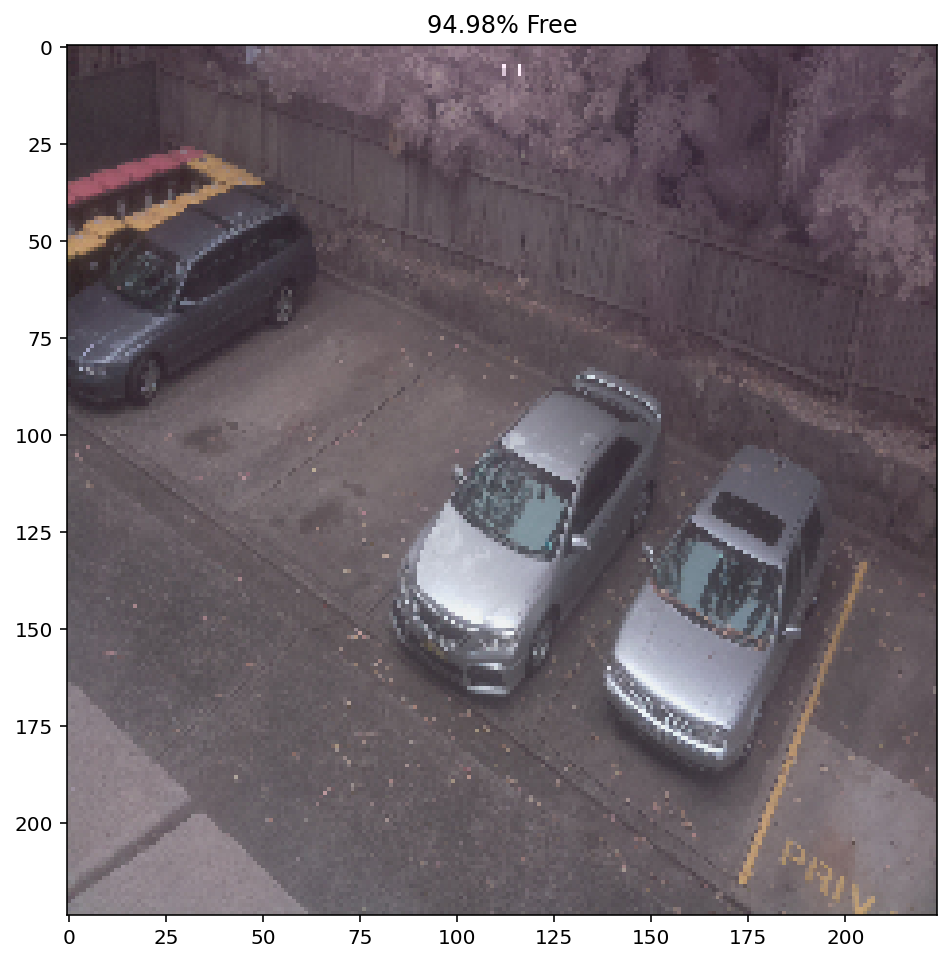

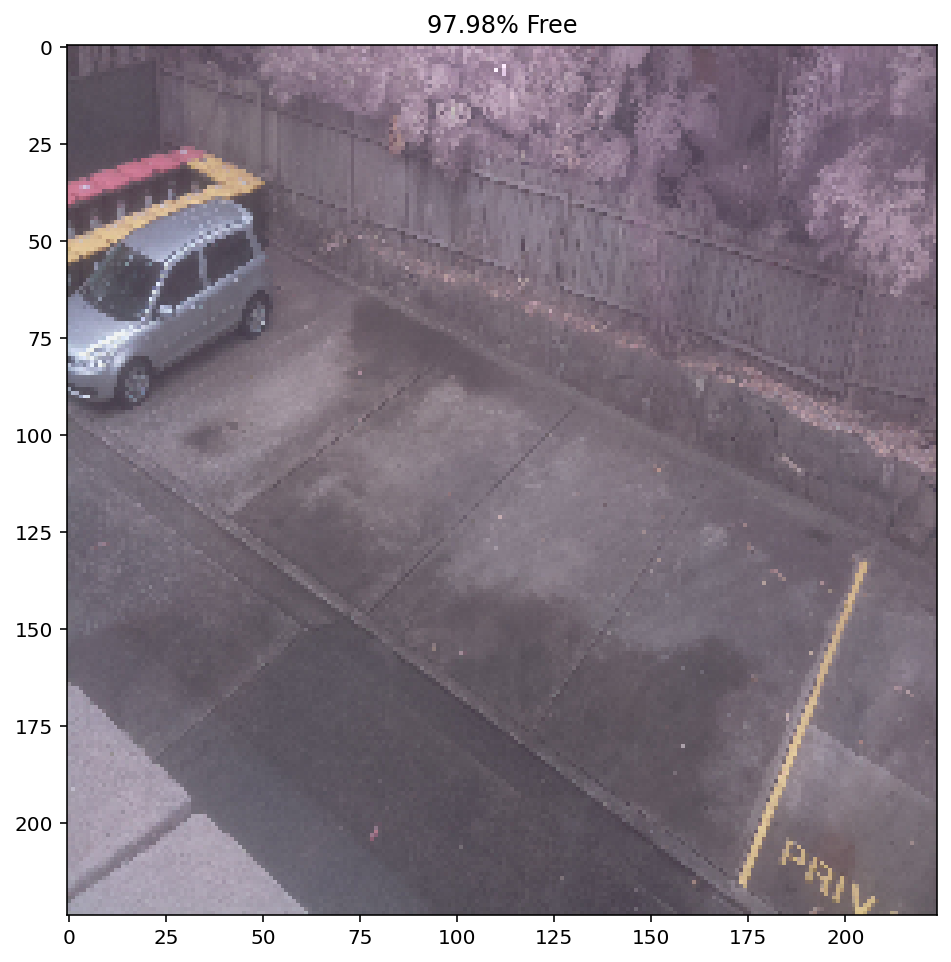

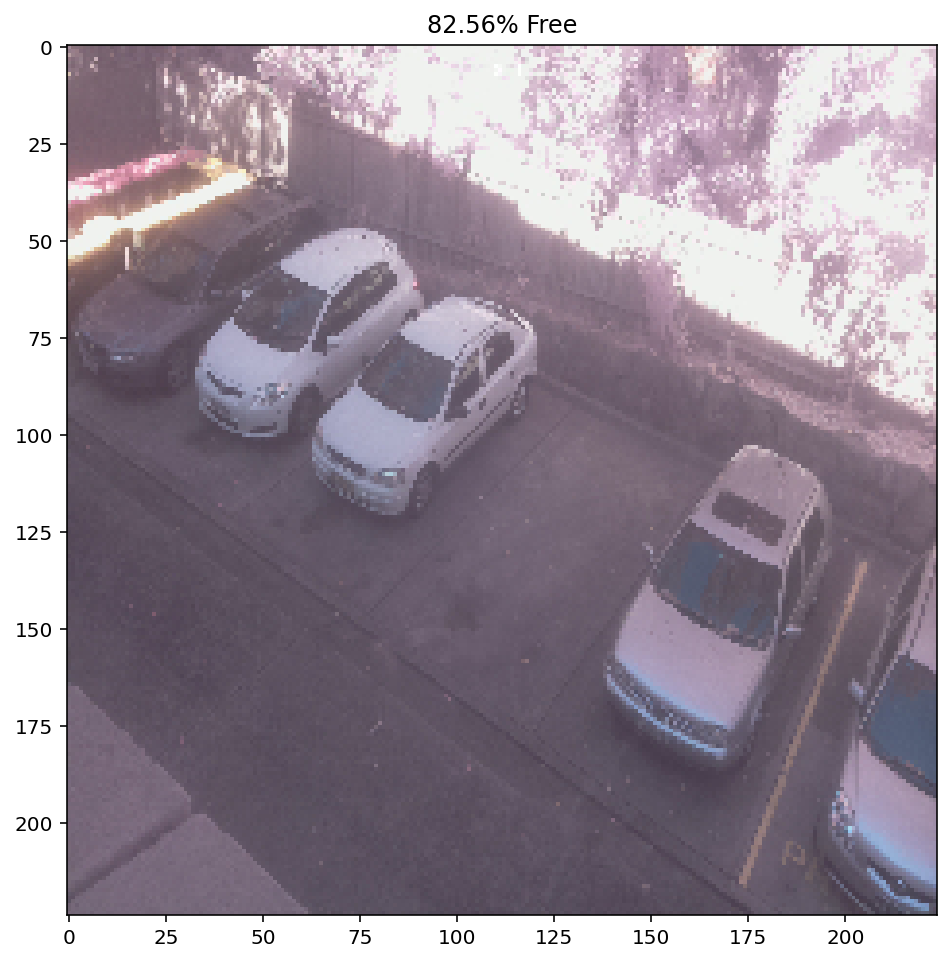

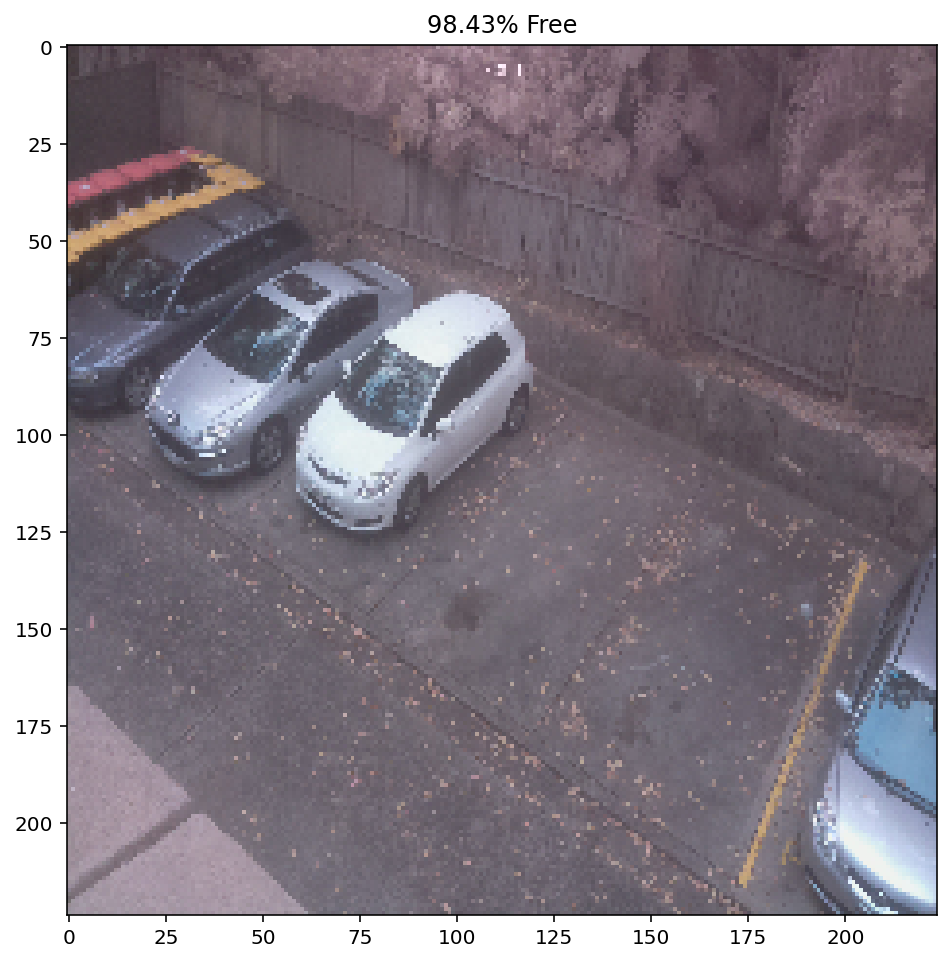

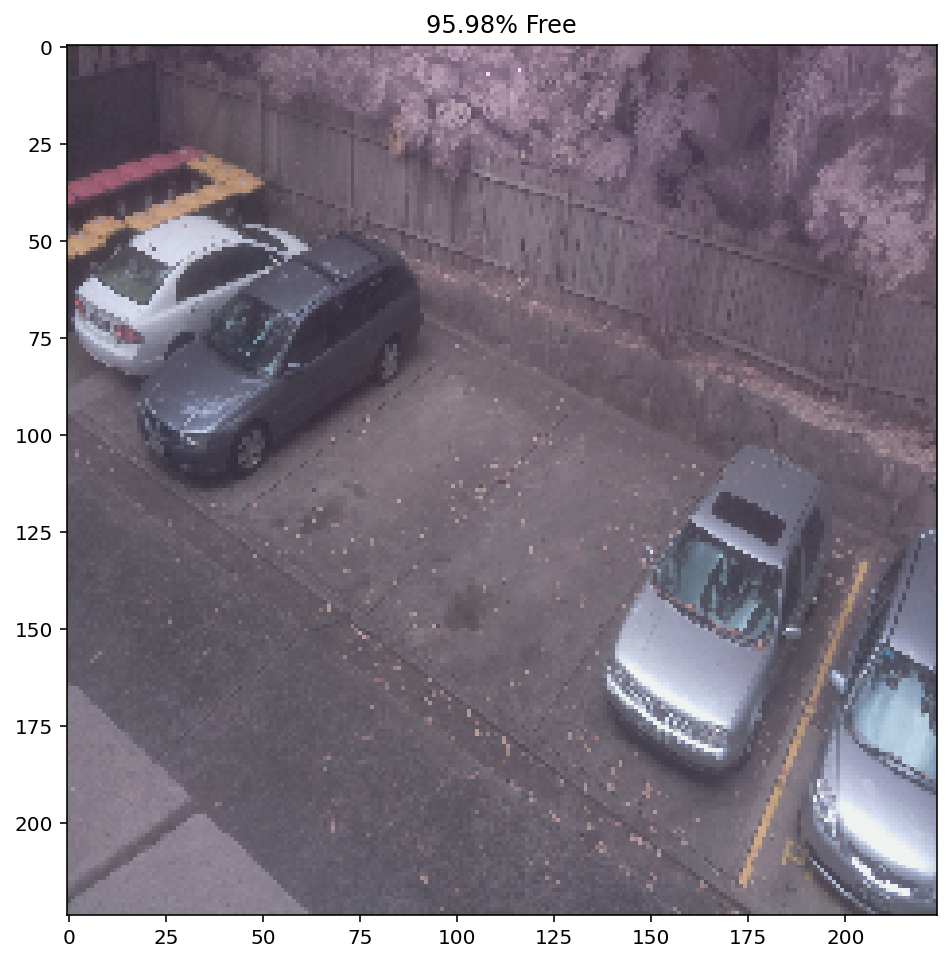

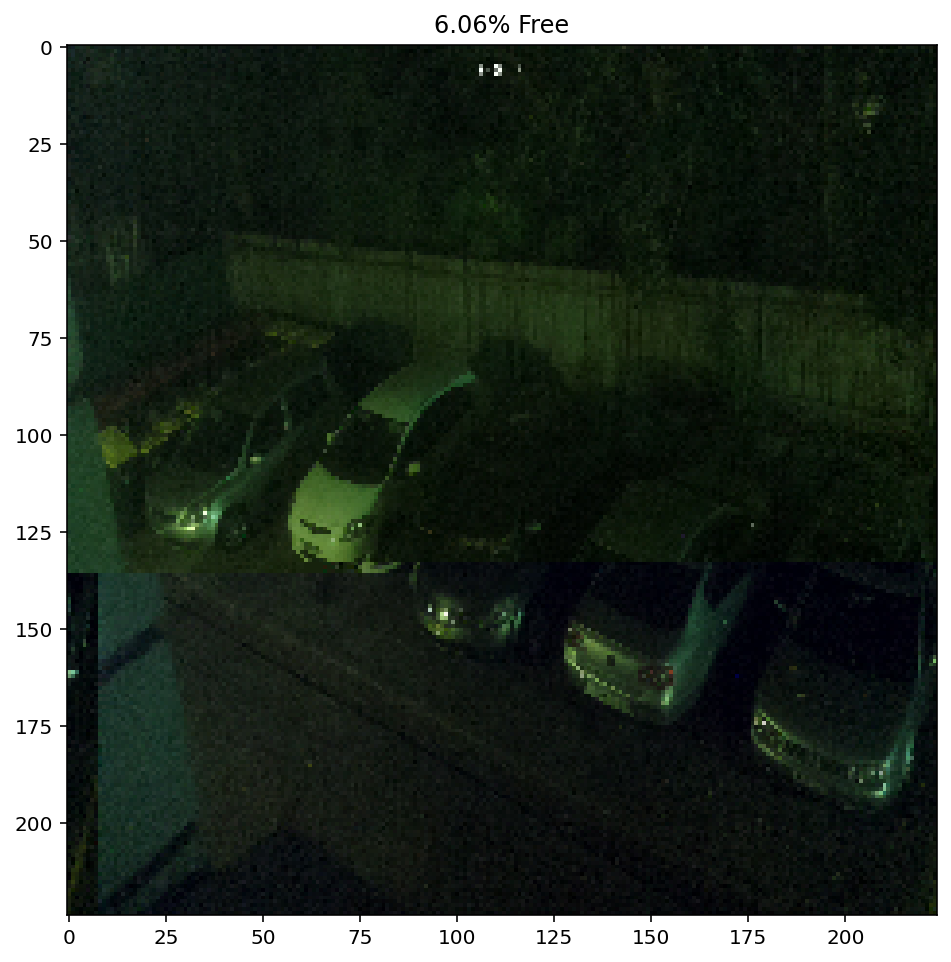

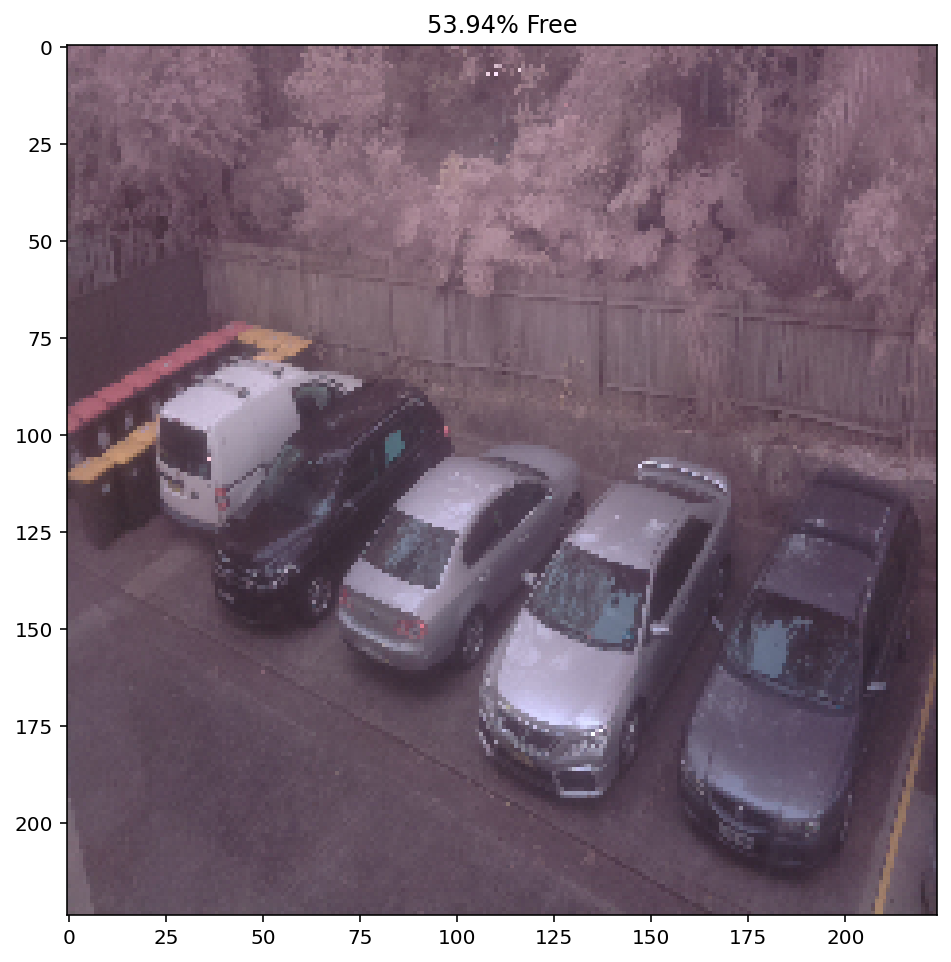

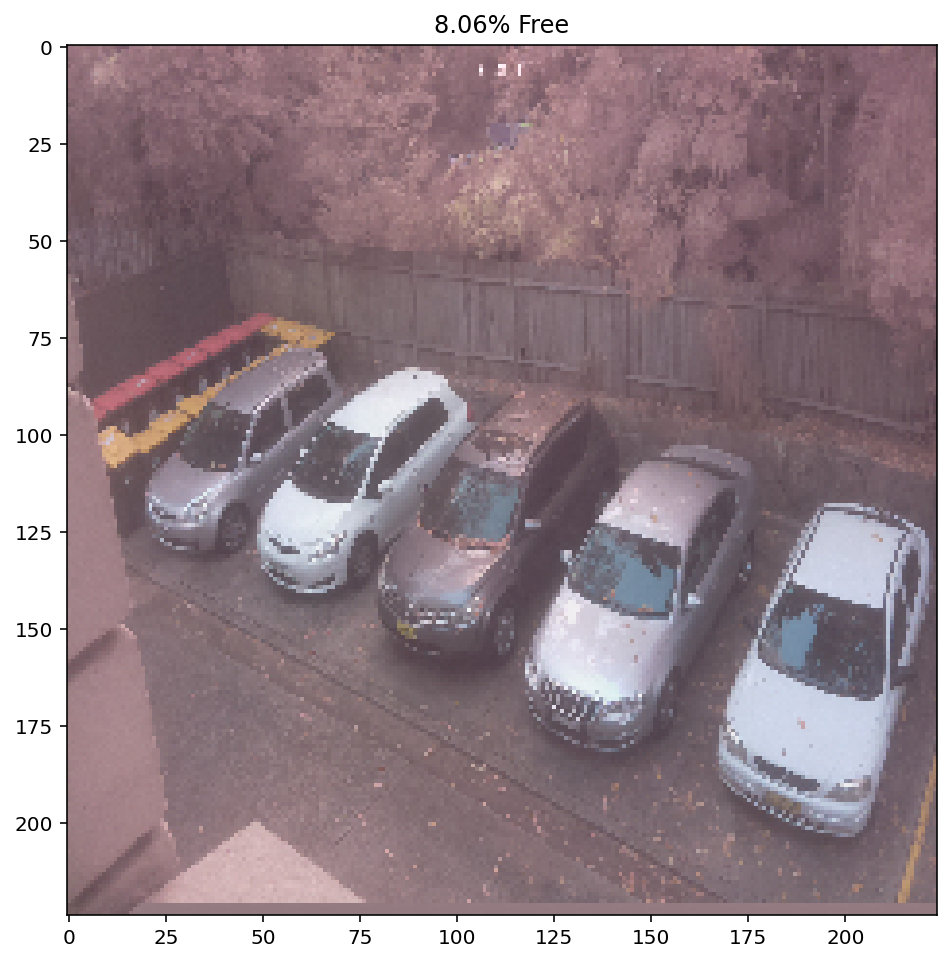

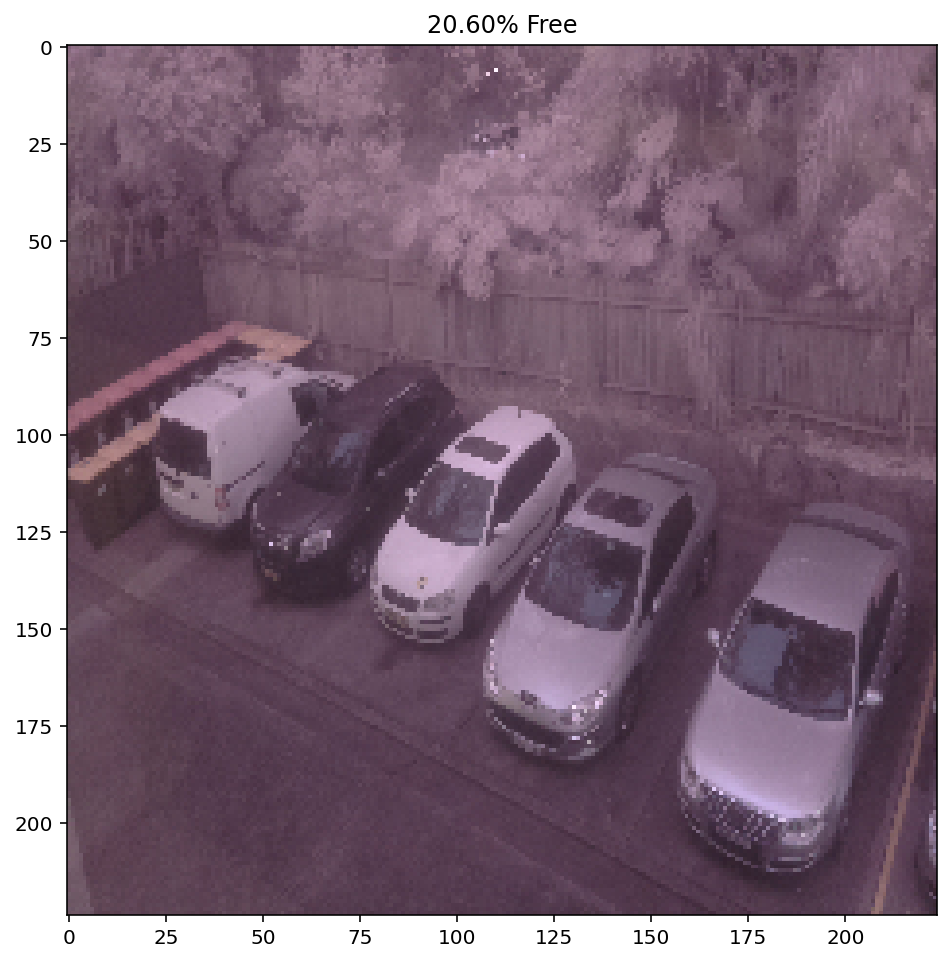

In [47]:
# 모델 이용하여 샘플사진에 대한 예측결과 확인
parking_list=['Free/img_1008151058.jpg',
              'Free/img_1011134058.jpg',
              'Free/img_1006160558.jpg',
              'Free/img_1010183058.jpg',
              'Free/img_1009171557.jpg',
              'Full/img_127040601.jpg',
              'Full/img_809172559.jpg',
              'Full/img_129063058.jpg',
              'Full/img_822174600.jpg']

for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(img_dir, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0)) # 테스트할 사진 전처리함수 이용해 전처리
    pred = model.predict(test_input) # 클래스 예측
    
    plt.figure(figsize=(8,8))
    plt.title('%.2f%% Free' % (pred[0][1]*100))
    plt.imshow(test_img.astype(np.uint8))

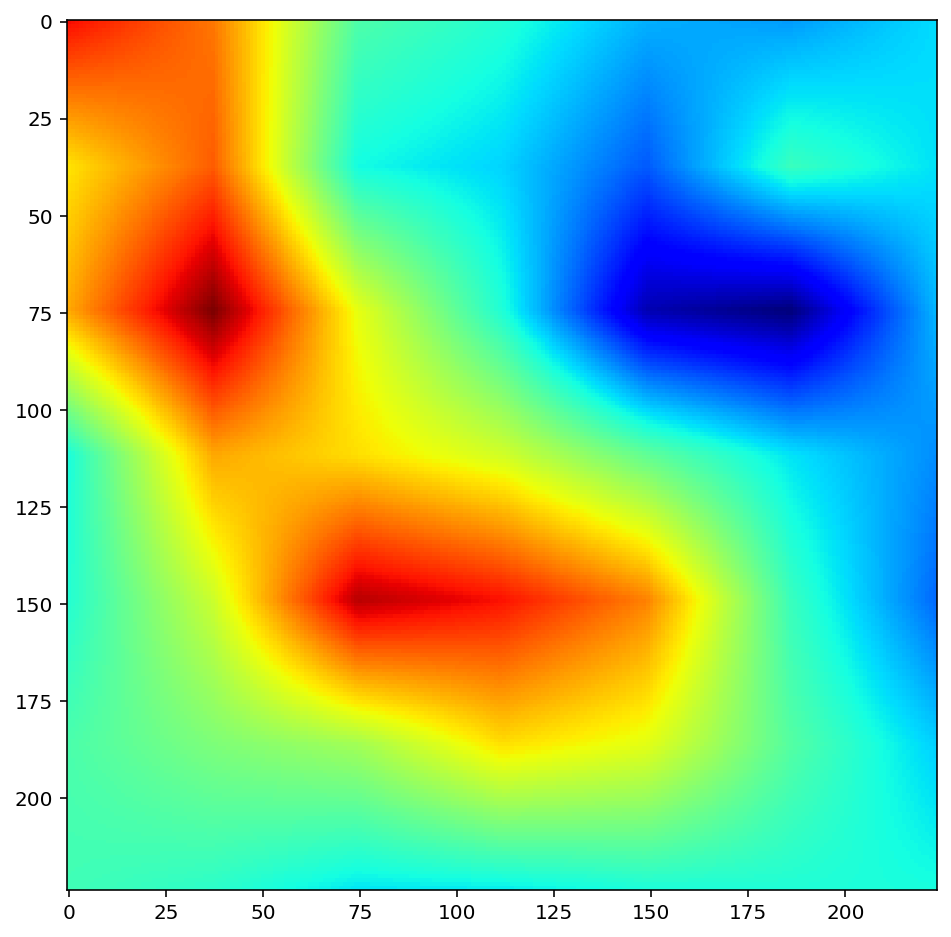

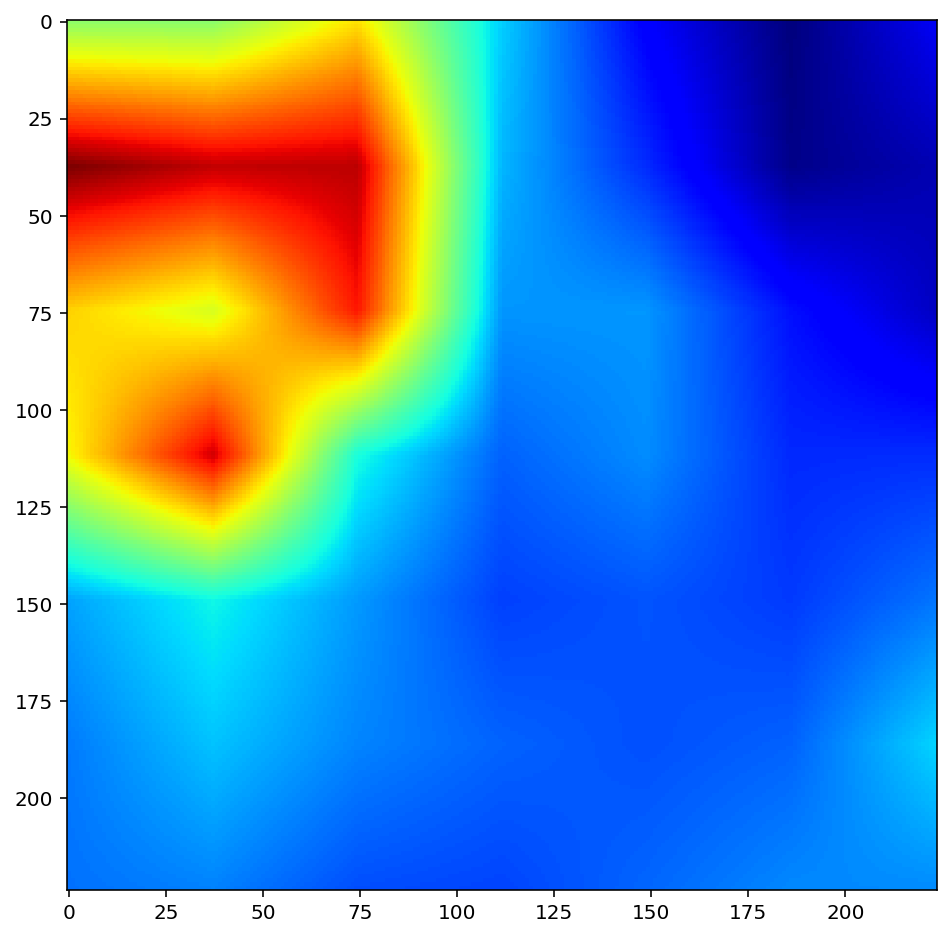

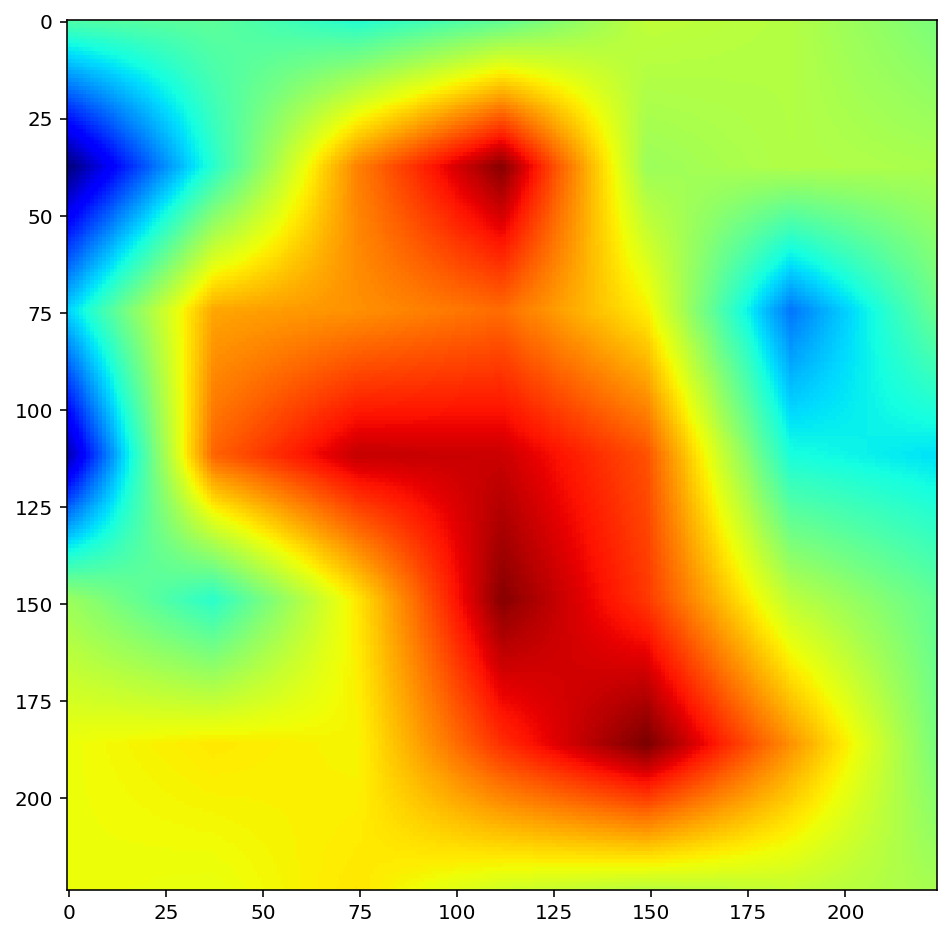

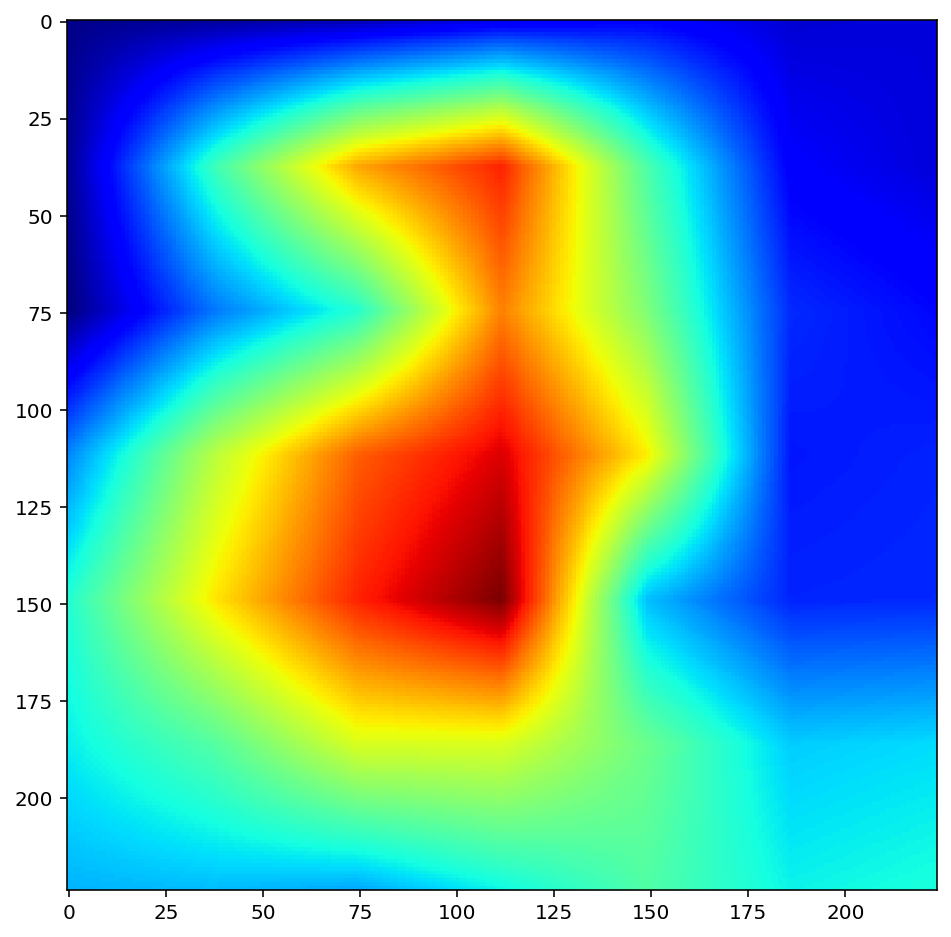

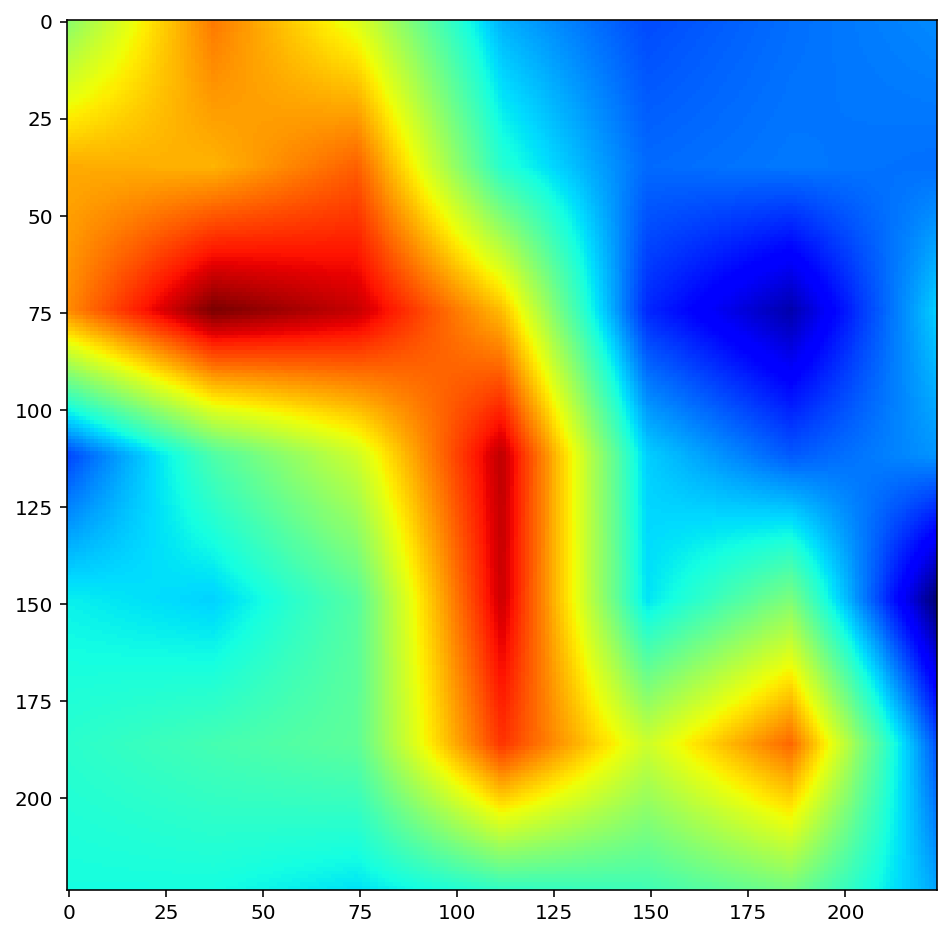

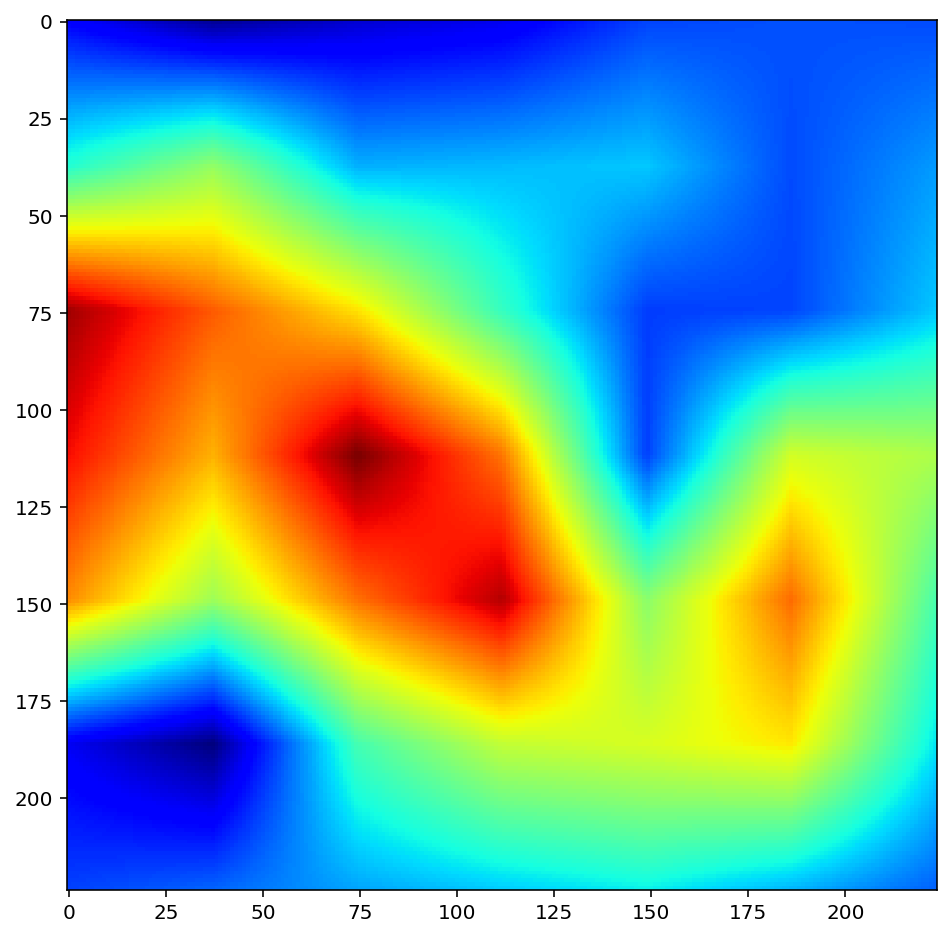

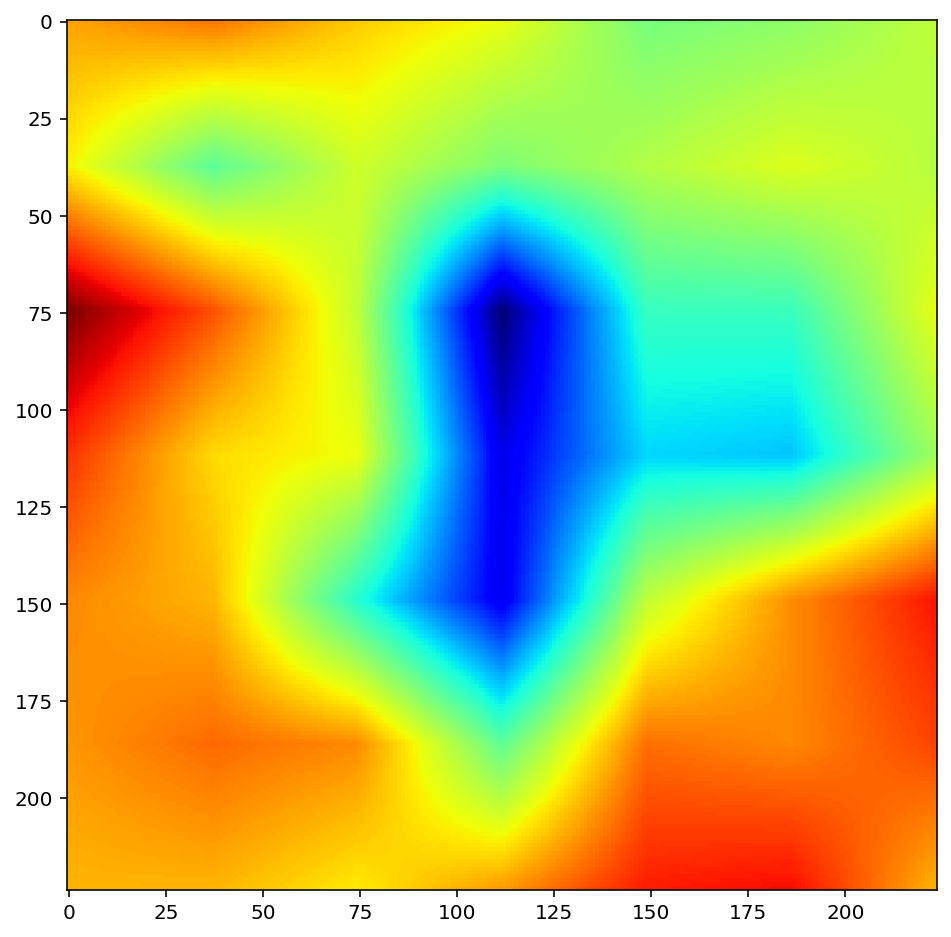

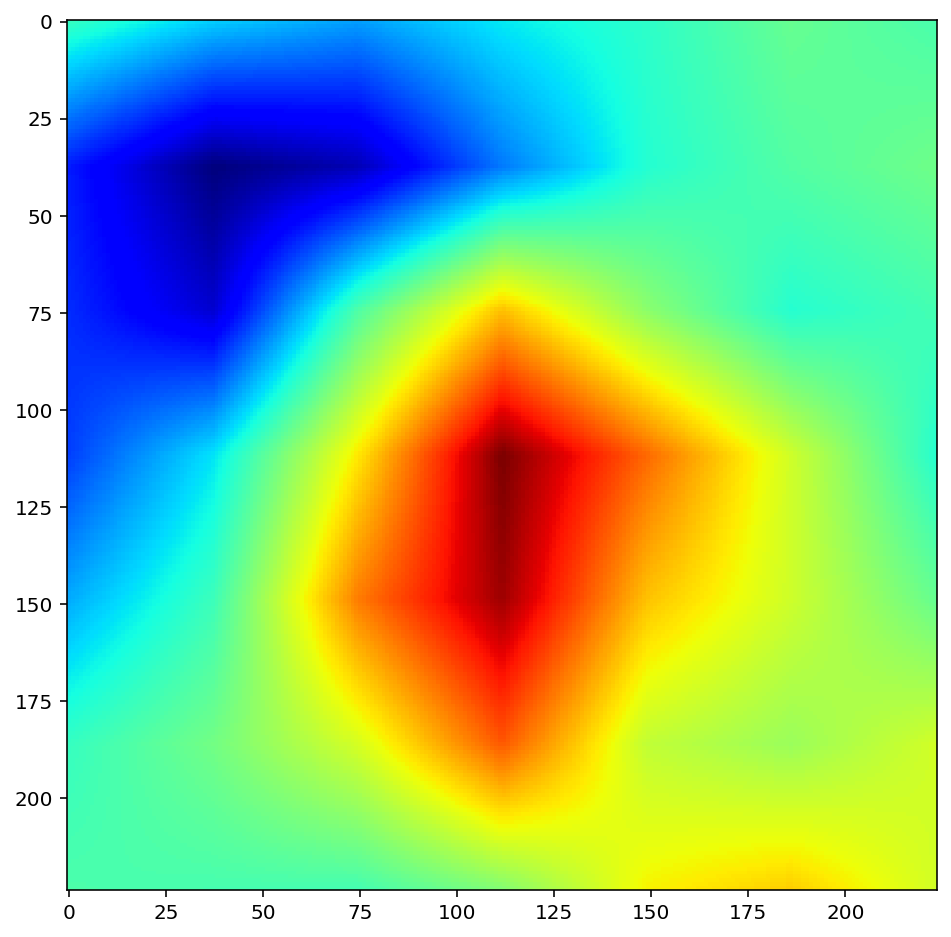

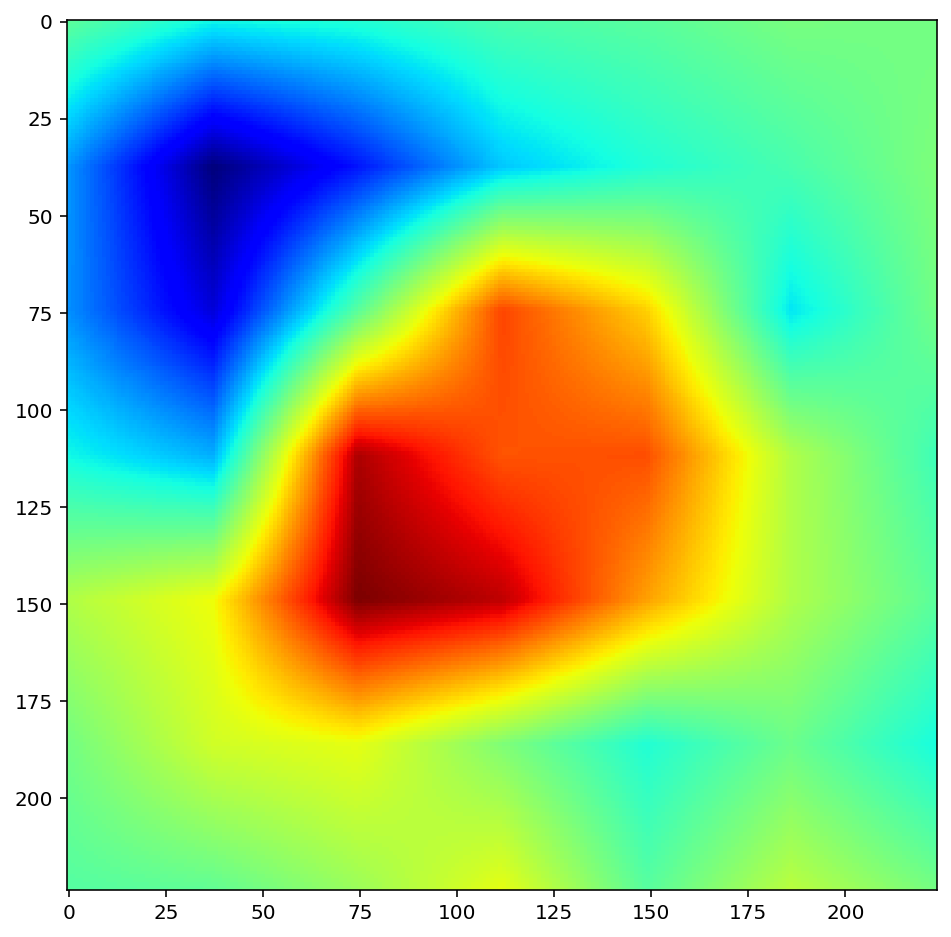

In [48]:
# Class Activation Map확인 (CAM)
import scipy


for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(img_dir, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)    # 클래스 예측
    
    # new_model에 테스트 이미지를 넣어서 나온 아웃풋 두 개를 각각 last_conv_output, pred(기존 모델의 아웃풋임) 변수에 저장 
    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # 1차원 배열로 축소함 (7, 7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (224, 224, 1280)의 이미지로 만들기 위해 32배 확대
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # argmax통해서 예측한 클래스를 알아냄. 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # 마지막 가중치에서 해당 클래스의 가중치만을 인덱싱하여 뽑아줌 (1280, 1)
    
    # feature_activation_maps과 predicted_class_weights를 곱해줌(globalaveragepooling 건너뛰기 위함 = globalaveragepooling을 하면 공간적인 정보가 사라지므로) 
    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1) 인풋이미지와 똑같은 사이즈가 됨
    
    plt.figure(figsize=(8,8))
    plt.imshow(final_output, cmap='jet')

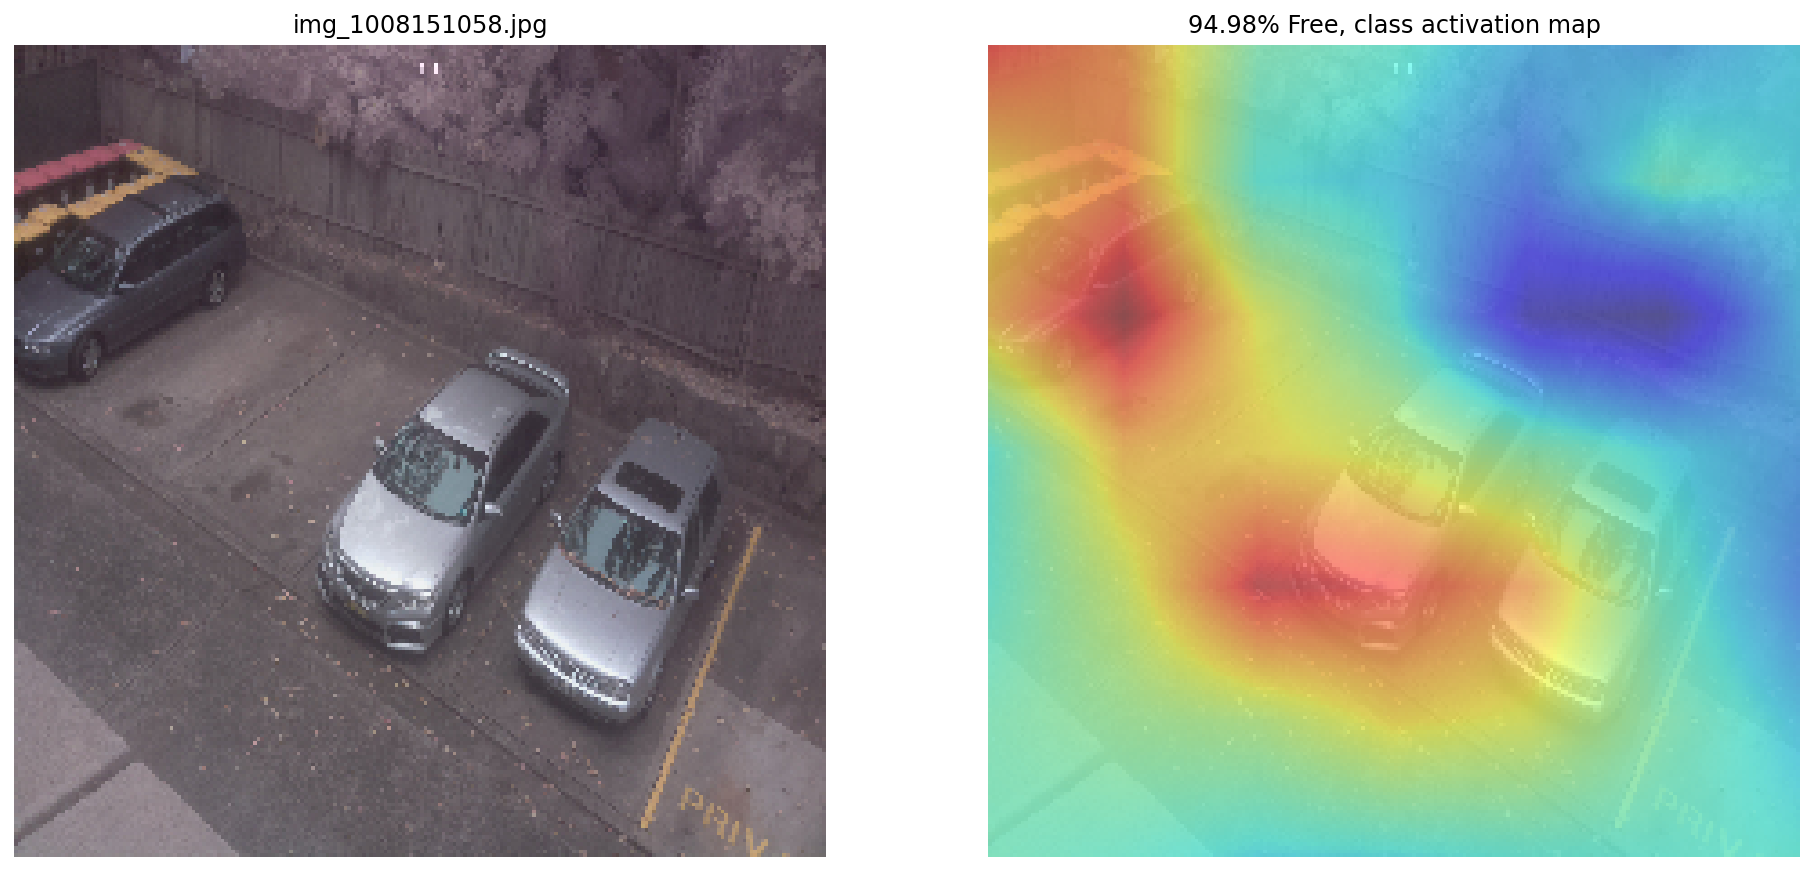

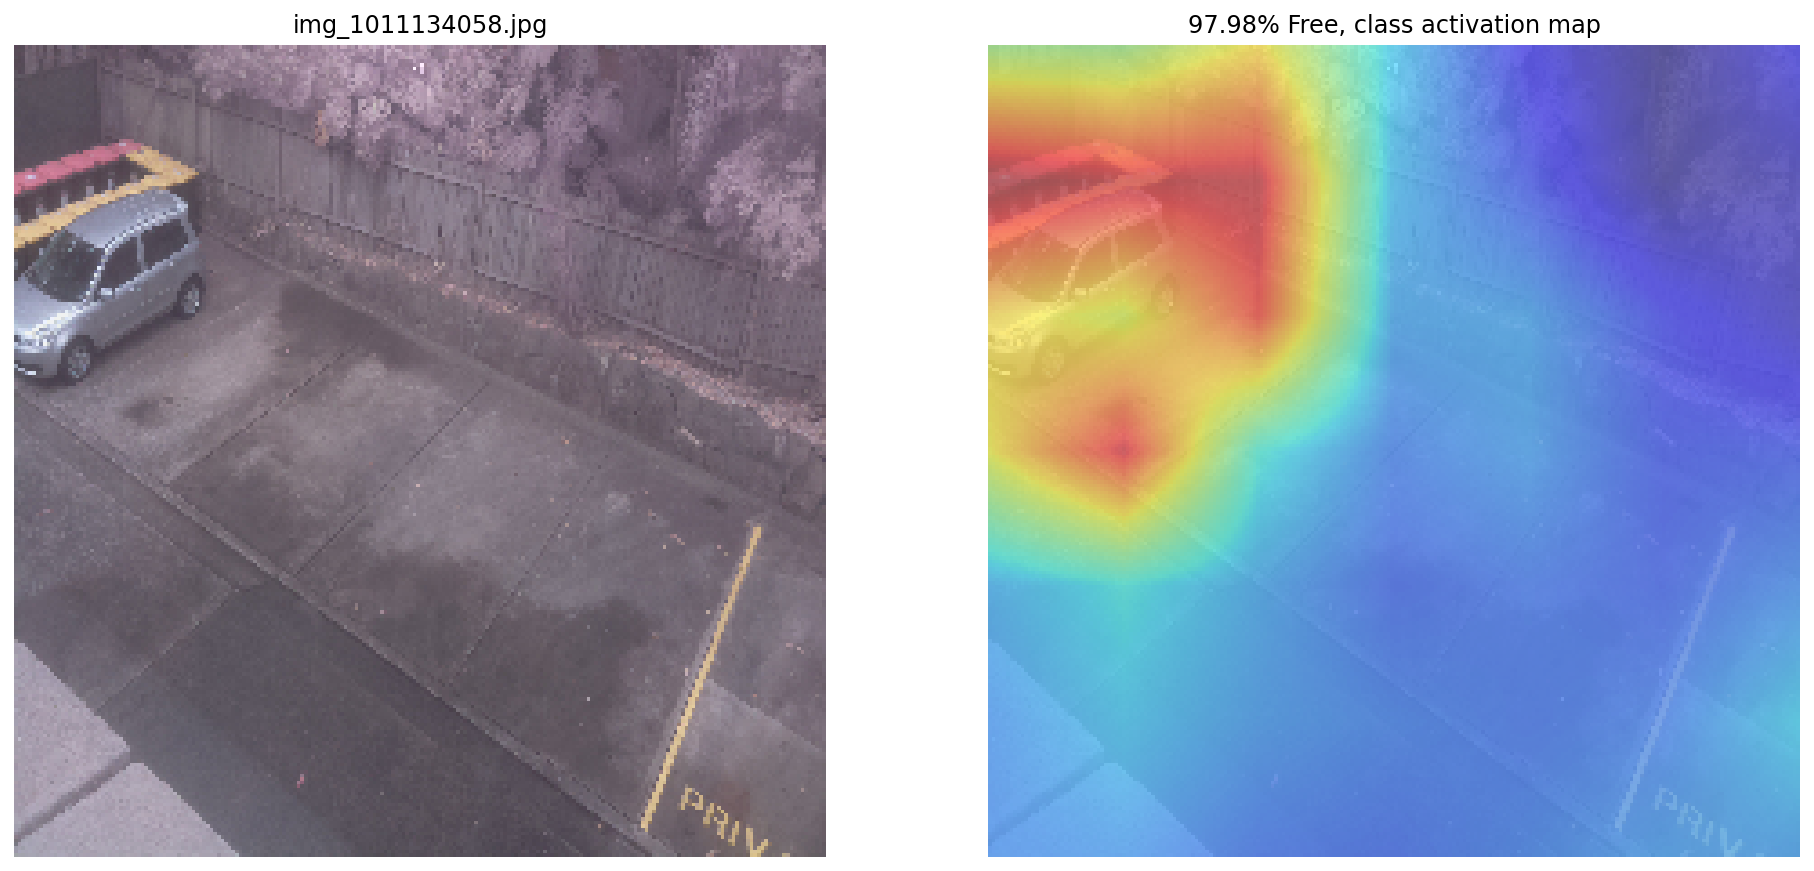

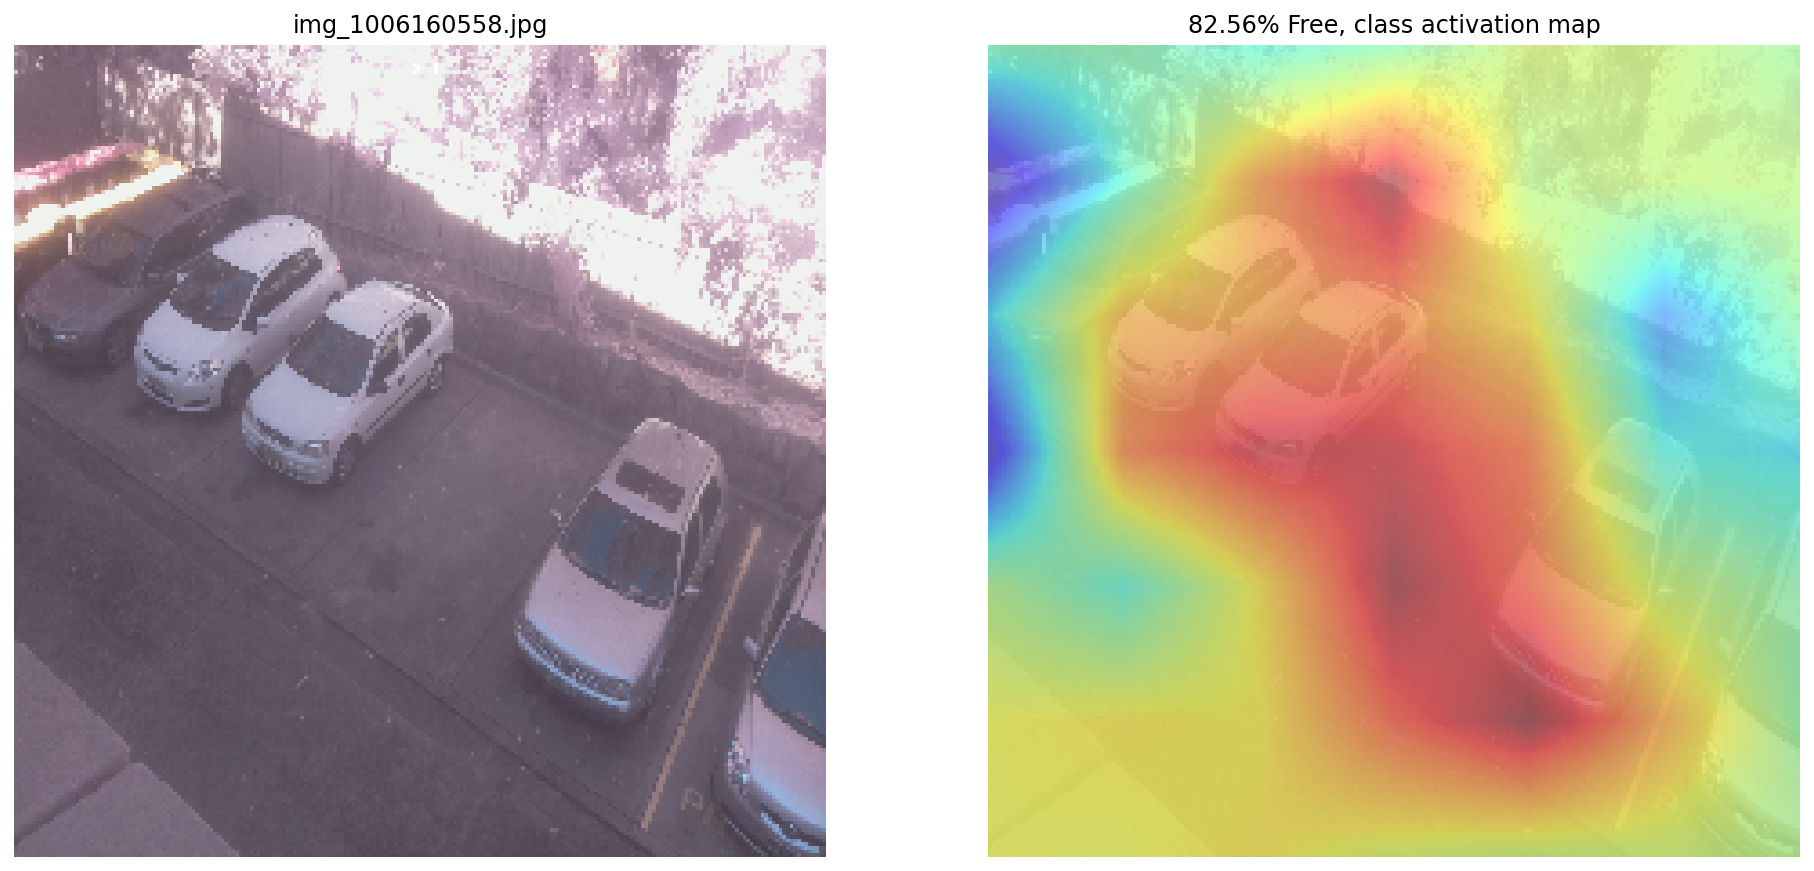

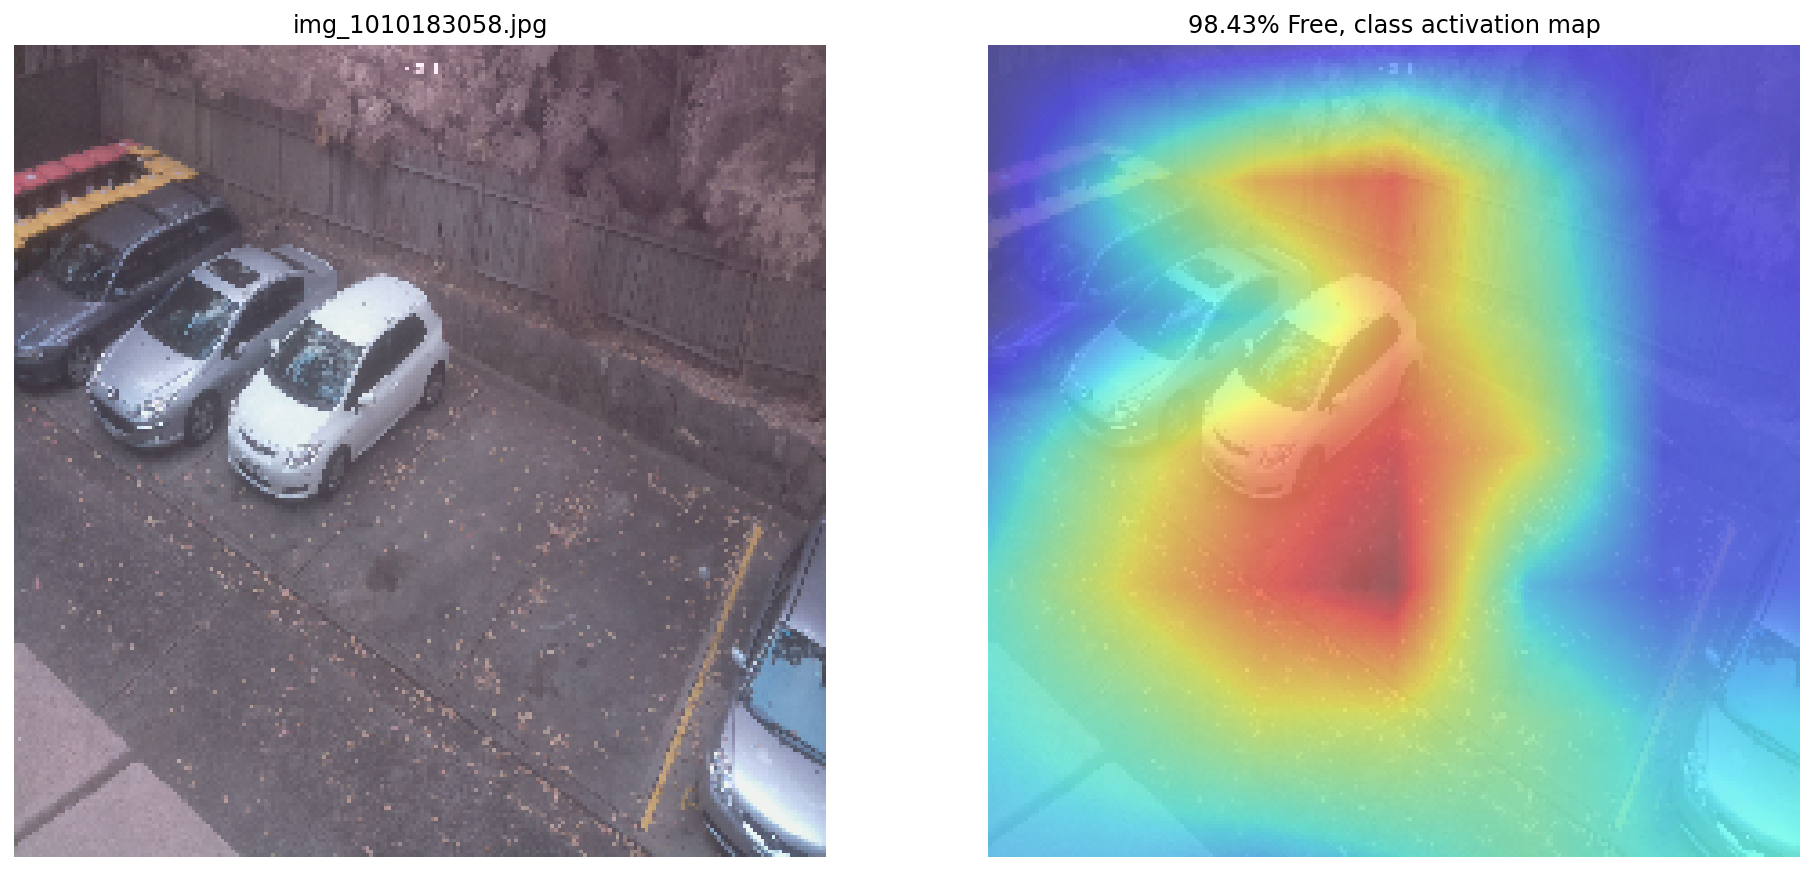

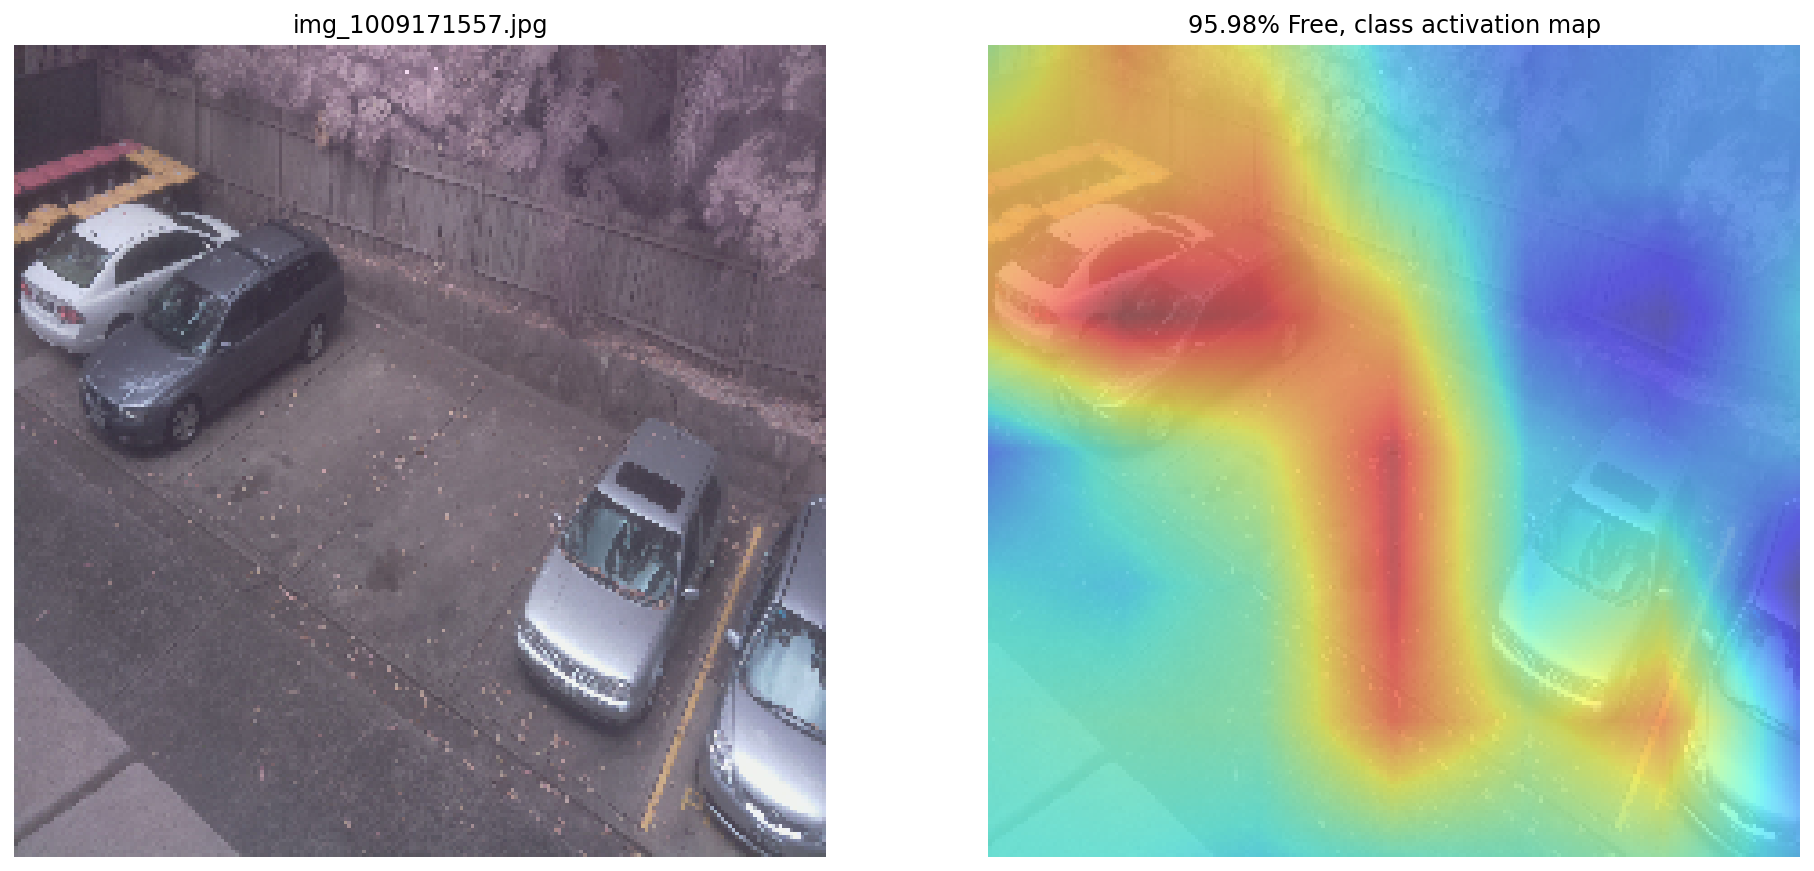

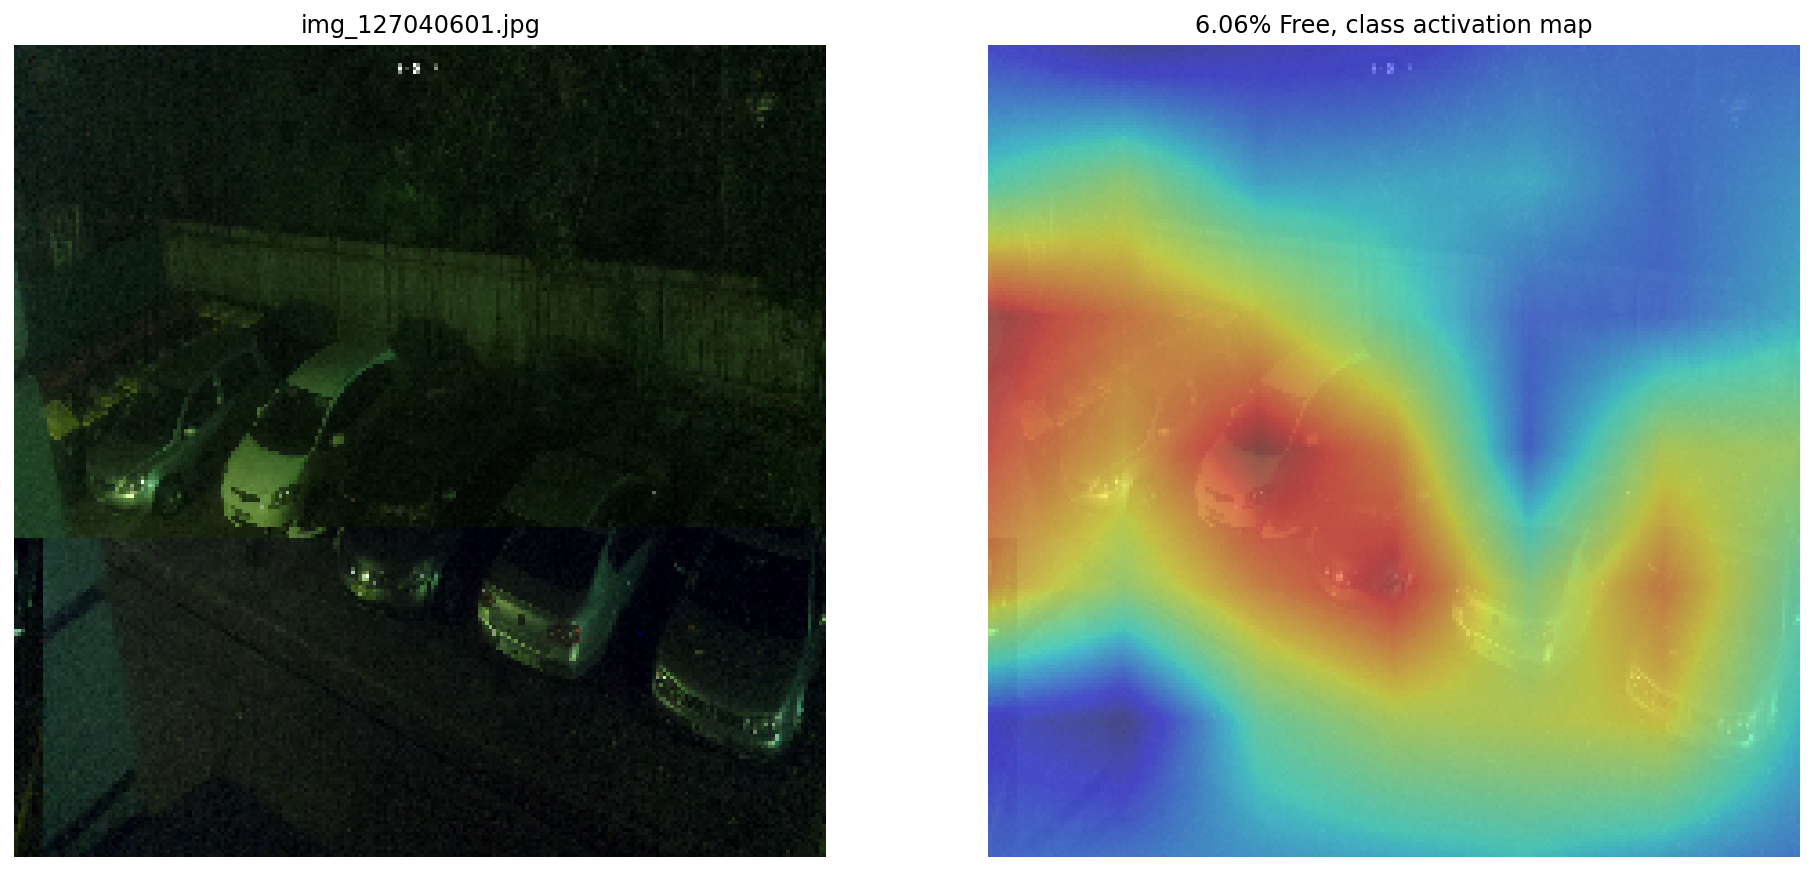

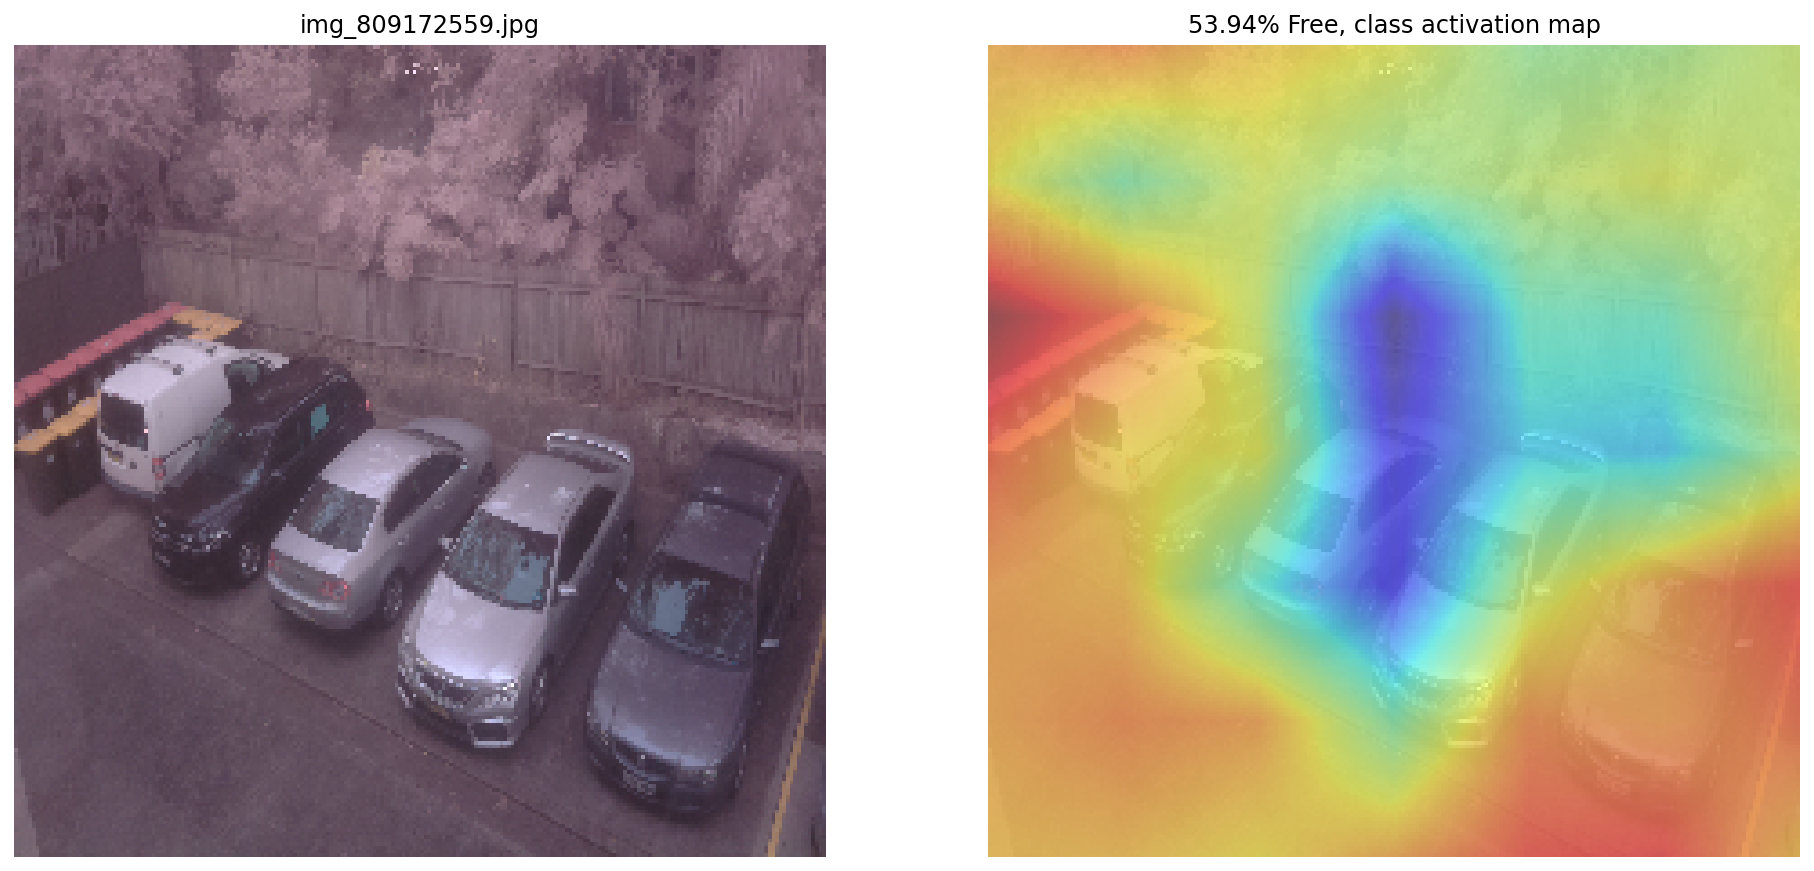

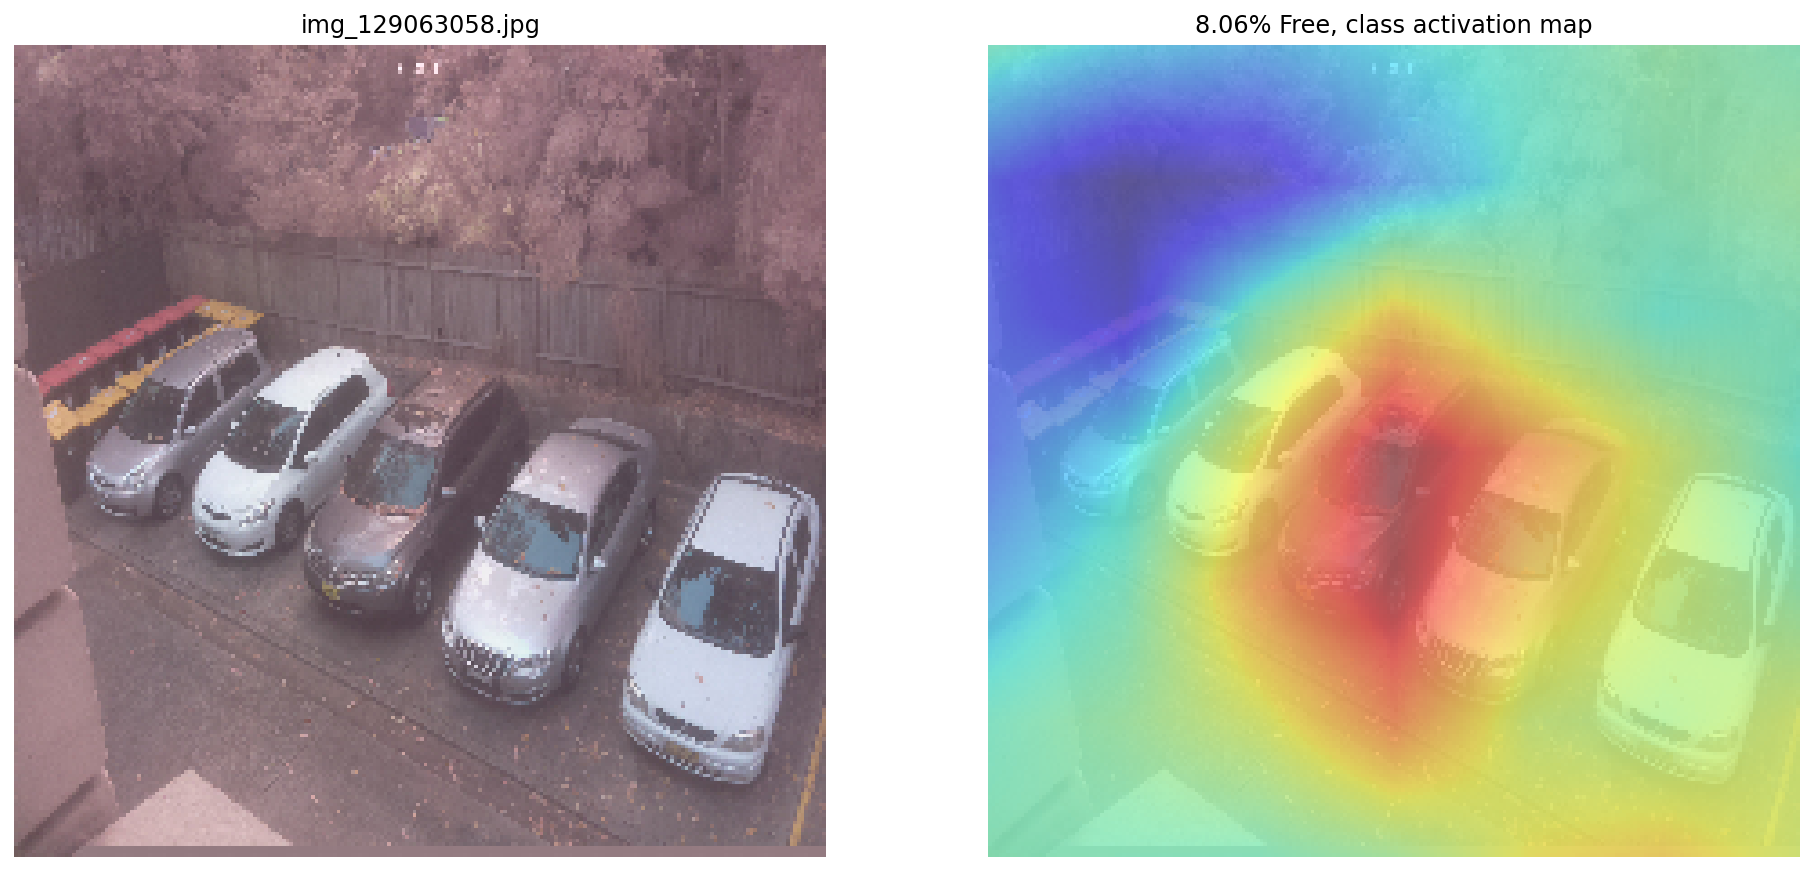

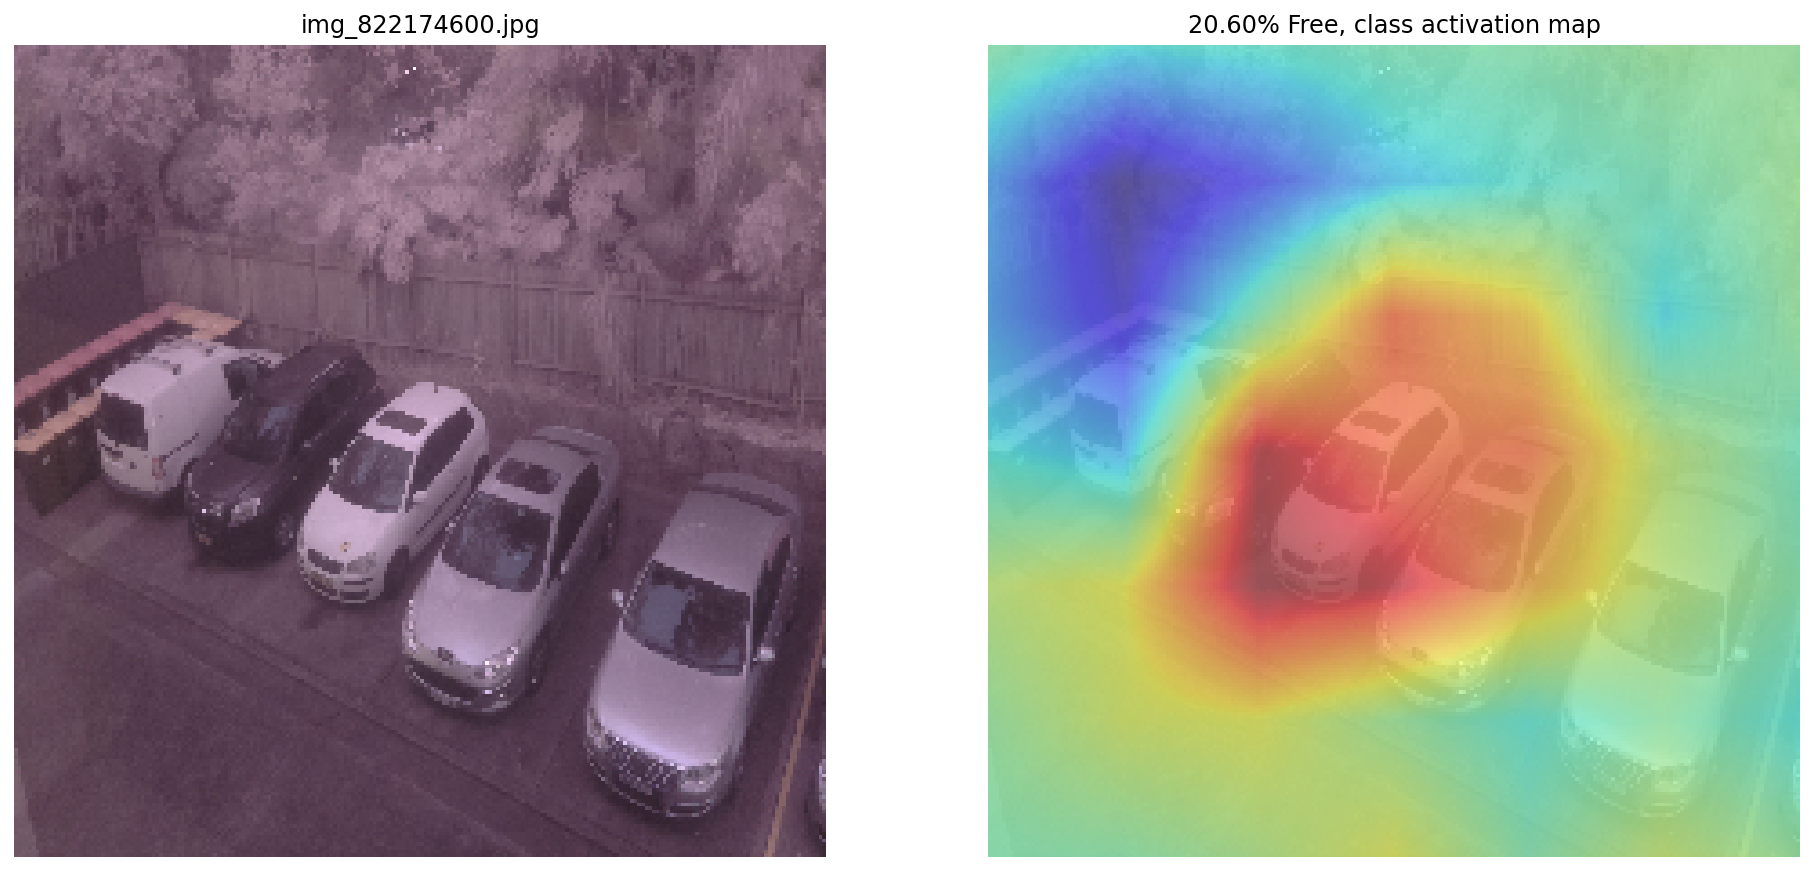

In [49]:
# CAM과 인풋사진 오버랩하여, 모델이 인풋사진의 어느 부분을 보고 클래스를 예측했는지 확인할 수 있음
for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(img_dir, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 20)

    ax[0].imshow(test_img.astype(np.uint8))
    ax[0].set_title(parking.split('/')[1])
    ax[0].axis('off')

    ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[1].imshow(final_output, cmap='jet', alpha=0.5)
    ax[1].set_title('%.2f%% Free, class activation map' % (pred[0][1]*100))
    ax[1].axis('off')
    plt.show()